# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Exercicio</p></div> 

# Resumo

Modelos de score de crédito calculam a probabilidade de inadimplência e são uma das principais ferramentas utilizadas por diversas empresas para aprovar ou negar um crédito. Para o desafio, são disponibilizadas 3 bases de dados contendo informações de cada cliente e transação realizada por ele.


# Objetivo

- Criar um modelo preditivo calculando a probabilidade de inadimplência de cada novo pedido de crédito realizado por um cliente recorrente.


# Conteúdo

- Libraries and Settings
- Loading Data
- Labeling
- Preprocessing
- Exploratory Data Analysis
- Data Preparation
- Machine Learning Model
- Hypertuning
- Explainability
- Submission

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Libraries and Settings</p></div> 

In [1]:
# Ferramentas Basicas
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import re
import time

# Ferramentas de visualização
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Modelos de Machine Learning
import lightgbm
from lightgbm import LGBMClassifier, plot_importance
import xgboost
from xgboost import XGBClassifier, plot_importance

# Ferramentas de amostragem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_validate, StratifiedKFold

# Ferramenta de ajuste de hiperparametros
import optuna

# Ferramentas para avaliação do modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Ferramentas para Preparação dos Dados
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

# Ferramentas para avaliação da importancia/explicabilidade do modelo
import shap

# Global Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
%load_ext watermark

In [3]:
%watermark -a 'Alysson Machado Rezende Vidal' -d -v -p pandas,scikit-learn,lightgbm,xgboost,optuna,shap

Author: Alysson Machado Rezende Vidal

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pandas      : 1.5.1
scikit-learn: 0.0.post1
lightgbm    : 3.3.5
xgboost     : 1.7.4
optuna      : 3.1.1
shap        : 0.41.0



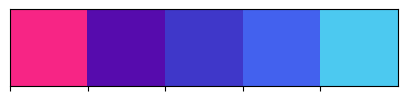

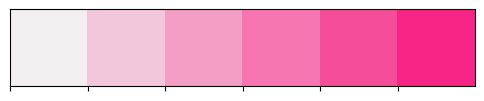

In [4]:
# Configurações de Layout, Matlab e Seaborn
CUSTOM_PALETTE = ["#f72585", "#560bad", "#3f37c9", "#4361ee", "#4cc9f0"]
sns.set_palette(sns.color_palette(CUSTOM_PALETTE))

cm = sns.light_palette("#f72585")

sns.palplot(sns.color_palette(CUSTOM_PALETTE))
sns.palplot(sns.color_palette(cm))

# colors = cm.as_hex()
# for color in colors:
#     print(color)

In [5]:
# Configurações do Jupyter Notebook / Pandas
pd.set_option('display.expand_frame_repr', False )
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 60)

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Loading Data</p></div> 

In [6]:
# Carregando os arquivos .csv no dirétorio do projeto
bc_raw = pd.read_csv('./data/base_cadastral.csv')
bi_raw = pd.read_csv('./data/base_info.csv')
bp_dev_raw = pd.read_csv('./data/base_pagamentos_desenvolvimento.csv')
bp_test_raw = pd.read_csv('./data/base_pagamentos_teste.csv')

In [7]:
bc_raw.shape, bi_raw.shape, bp_dev_raw.shape, bp_test_raw.shape

((1315, 8), (24401, 4), (77414, 7), (12275, 6))

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Labeling</p></div> 

In [8]:
bp_dev_mod = bp_dev_raw.copy()

In [9]:
bp_dev_mod['DATA_PAGAMENTO'] = pd.to_datetime(bp_dev_mod['DATA_PAGAMENTO'],format='%Y-%m-%d')
bp_dev_mod['DATA_VENCIMENTO'] = pd.to_datetime(bp_dev_mod['DATA_VENCIMENTO'],format='%Y-%m-%d')

In [10]:
# É considerado inadimplente se a quantidade de dias de débito for maior ou igual a 5
bp_dev_mod['DIAS_DEBITO'] = (bp_dev_mod.DATA_PAGAMENTO - bp_dev_mod.DATA_VENCIMENTO).dt.days
bp_dev_mod['INADIMPLENTE'] = bp_dev_mod['DIAS_DEBITO'].apply(lambda x: 1 if x >= 5 else 0)
bp_dev_raw.shape, bp_test_raw.shape

((77414, 7), (12275, 6))

In [11]:
# Unindo os três dataframes para a base de treino e a base de teste
train_raw = pd.merge(bc_raw, pd.merge(bi_raw, bp_dev_mod, on=['ID_CLIENTE','SAFRA_REF'], how='right'), on='ID_CLIENTE', how='right')
test_raw = pd.merge(bc_raw, pd.merge(bi_raw, bp_test_raw, on=['ID_CLIENTE','SAFRA_REF'], how='right'), on='ID_CLIENTE', how='right')
train_raw.shape, test_raw.shape

((77414, 18), (12275, 15))

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Preprocessing</p></div>

### Premissas do Preprocessamento:

Foram encontradas algumas inconsistencias no dados, disponibilizados apesar não impedirem o andamento do projeto numa situação real precisariam ser verificadas já que impactam diretamente na predição do modelo. A limpeza dos dados foi feita para todos as colunas independente da utilidade no modelo.

- Os dados relativos ao "PORTE" da empresa possuí algumas informações inconsistentes de acordo com a reportagem sugerida no link. Por causa disso essa coluna foi desconsiderada na construção do modelo... https://exame.com/invest/btg-insights/como-definir-o-porte-de-uma-empresa/

In [12]:
df = train_raw.copy()

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Cleaning</p></div>

- Os dados relativos ao "DDD" possuem alguns valores sujos exempplo: "(9" ,"(0", "(1", etc... eles foram substituídos por "09" , "00", "01", por serem consideradas substituições mais intuítivas mas ainda sim são hipoteses pois eles podem não ser de fato esses valores.

- A coluna FLAG_PF teve sua nomenclatura altera no projeto para 1/0 que representa pessoa fisica/juridica respectivamente. Utilizar "nan" como valor para pessoa juridica não é uma boa prática e pode ser prejudicial ao projeto já que podemos perder a capacidade de diferenciar nan no sentido de "not a number" e nan no sentido de "pessoa juridica".

In [13]:
df['DDD'].unique()

array(['99', '31', '75', '49', '88', '18', '67', '21', '11', '44', nan,
       '19', '14', '16', '85', '41', '51', '12', '62', '43', '91', '42',
       '61', '33', '48', '71', '65', '38', '24', '(3', '47', '28', '(2',
       '81', '35', '13', '86', '94', '45', '17', '55', '64', '69', '32',
       '(6', '27', '66', '63', '46', '(1', '54', '77', '34', '74', '37',
       '53', '56', '95', '22', '73', '(9', '(4', '52', '87', '98', '(8',
       '92', '82', '79', '93', '83', '00', '(5', '15', '02', '84', '(0',
       '04', '07'], dtype=object)

In [14]:
df['CEP_2_DIG'].unique()

array(['65', '77', '48', '89', '62', '19', '38', '26', '55', '87', '37',
       '22', '13', '18', '21', '98', '14', '60', '82', '92', '79', '12',
       '27', '76', '67', '72', '68', '11', '84', '70', '83', '88', '75',
       '36', '45', '44', '16', '42', '78', '31', '41', '35', '51', '30',
       '86', '25', '29', '17', '23', '20', '93', '64', '95', '85', '15',
       '99', '80', '24', '61', '90', '50', '96', '97', '57', '46', '47',
       '32', '54', '91', '56', '28', '71', '33', '94', '58', '34', '59',
       '69', '74', '40', '49', '43', '66', '39', '73', '81', '53', '52',
       '63', 'na'], dtype=object)

In [15]:
df['FLAG_PF'].unique()

array([nan, 'X'], dtype=object)

In [16]:
def Cleaning(df: pd.DataFrame):
    
    ## Substitui os caracteres não numéricos por "0" e os caracteres com "000" por "NaN"
    df['DDD'] = df['DDD'].astype(str)
    df['DDD'] = df['DDD'].apply(lambda x: re.sub(r'\D', '0', x)).replace('000', np.nan).astype(float) 
    
    ## Substitui "na"por "NaN"
    df['CEP_2_DIG'] = df['CEP_2_DIG'].replace('na', np.nan).astype(float)
    
    ## Substitui "X" por "1" e "np.nan" por "0"
    flag_dict = {'X': 1,  np.nan:0}
    df['FLAG_PF'] = df['FLAG_PF'].map(flag_dict).astype(int)
    
    return df  

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Type</p></div>

In [17]:
df.dtypes

ID_CLIENTE                         int64
DATA_CADASTRO                     object
DDD                               object
FLAG_PF                           object
SEGMENTO_INDUSTRIAL               object
DOMINIO_EMAIL                     object
PORTE                             object
CEP_2_DIG                         object
SAFRA_REF                         object
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                  float64
DATA_EMISSAO_DOCUMENTO            object
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
DIAS_DEBITO                        int64
INADIMPLENTE                       int64
dtype: object

In [18]:
def DataType(df: pd.DataFrame):
    
    df['DATA_CADASTRO'] = pd.to_datetime(df['DATA_CADASTRO'],format='%Y-%m-%d')
    df['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df['DATA_EMISSAO_DOCUMENTO'],format='%Y-%m-%d')
    df['DATA_VENCIMENTO'] = pd.to_datetime(df['DATA_VENCIMENTO'],format='%Y-%m-%d')
    df['SAFRA_REF'] = pd.to_datetime(df['SAFRA_REF'],format='%Y-%m-%d')#.dt.to_period('M')
    df['CEP_2_DIG'] = df['CEP_2_DIG'].astype('float64')
    df['RENDA_MES_ANTERIOR'] = df['RENDA_MES_ANTERIOR'].astype('float64')
    df['NO_FUNCIONARIOS'] = df['NO_FUNCIONARIOS'].astype('float64')     
    
    df['VALOR_A_PAGAR'] = df['VALOR_A_PAGAR'].round(2)
    df['RENDA_MES_ANTERIOR'] = df['RENDA_MES_ANTERIOR'].round(2)
    
    return df

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Missing Values</p></div>

- A principio nenhuma coluna será excluída mesmo que algumas delas pouco beneficiem o modelo. Na etapa de "Feature Selection" que serão decididas quais features a serem utilizadas e os motivos dessa decisão.

- As linhas que possuem valores faltantes serão imputados valores como média, moda, mediana. quartil, etc...

In [19]:
train_raw.isna().sum()

ID_CLIENTE                    0
DATA_CADASTRO                 0
DDD                        7414
FLAG_PF                   77195
SEGMENTO_INDUSTRIAL        1417
DOMINIO_EMAIL               898
PORTE                      2476
CEP_2_DIG                     0
SAFRA_REF                     0
RENDA_MES_ANTERIOR         3937
NO_FUNCIONARIOS            3937
DATA_EMISSAO_DOCUMENTO        0
DATA_PAGAMENTO                0
DATA_VENCIMENTO               0
VALOR_A_PAGAR                 0
TAXA                          0
DIAS_DEBITO                   0
INADIMPLENTE                  0
dtype: int64

In [20]:
test_raw.isna().sum()

ID_CLIENTE                    0
DATA_CADASTRO                38
DDD                        1377
FLAG_PF                   12228
SEGMENTO_INDUSTRIAL         254
DOMINIO_EMAIL               208
PORTE                       416
CEP_2_DIG                    38
SAFRA_REF                     0
RENDA_MES_ANTERIOR          414
NO_FUNCIONARIOS             414
DATA_EMISSAO_DOCUMENTO        0
DATA_VENCIMENTO               0
VALOR_A_PAGAR                 0
TAXA                          0
dtype: int64

In [21]:
def ReplaceNan(df: pd.DataFrame):     
    
    '''
    DATA_CADASTRO: Se NaN, substituir pela data de SAFRA_REF
    DDD: Se NaN, substituir por um valor numerico qualquer não utilizavel
    FLAG_PF, CEP_2_DIG: Se NaN, subistituir pelo valor mais frequente 
    SEGMENTO_INDUSTRIAL, DOMINIO_EMAIL: Se NaN, substituir por "Desconhecido"
    PORTE: Se Nan, Substituir por "PEQUENO"
    
    '''
    nan_replacements = {"DATA_CADASTRO": df.apply(lambda row: row['SAFRA_REF'] if pd.isnull(row['DATA_CADASTRO']) else row['DATA_CADASTRO'], axis=1),
                        "DDD": 999,
                        "FLAG_PF": df['FLAG_PF'].mode()[0],                        
                        "SEGMENTO_INDUSTRIAL": 'Desconhecido',
                        "DOMINIO_EMAIL": 'DESCONHECIDO',
                        "PORTE": 'PEQUENO',
                        "CEP_2_DIG": df['CEP_2_DIG'].mode()[0],
                        "SAFRA_REF": df.apply(lambda row: row['DATA_EMISSAO_DOCUMENTO'] if pd.isnull(row['SAFRA_REF']) else row['SAFRA_REF'], axis=1),
                        "RENDA_MES_ANTERIOR": df['RENDA_MES_ANTERIOR'].quantile(0.2),
                        "NO_FUNCIONARIOS": df['NO_FUNCIONARIOS'].median()}
        
    df = df.fillna(nan_replacements) 
    
    return df

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Duplicated Values</p></div>

**Observação:**

Ao excluir a coluna de "DATA_PAGAMENTO" foram registrados alguns dados duplicados. Uma hipotese seria que o cliente pagou mais de uma vez a fatura outra hipotese é que seja apenas um erro no sistema. A principio esses dados duplicados serão mantidos da base de treino.

Outro cuidado importante é que a base de dados de teste possui valores duplicados e no caso desse exercicio não faz sentido deletar dados da base de teste.

In [22]:
df.duplicated(subset=['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA']).sum()

93

In [23]:
def DropDuplicated(df: pd.DataFrame):
    df = df.drop_duplicates(subset=['ID_CLIENTE','SAFRA_REF','DATA_EMISSAO_DOCUMENTO','DATA_VENCIMENTO','VALOR_A_PAGAR','TAXA'],  keep='first')  
    return df

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Feature Engieener</p></div>

Nessa etapa são criadas algumas features atraves da manipulação de datas, operações matemáticas, conhecimento do negócio, entre outros.

- Foi observado que 100% das vezes que a FLAG_PF indicava que era pessoa física, o SEGMENTO_INDUSTRIAL era "NaN", por causa disso foicriado um novo valor na coluna SEGMENTO_INDUSTRIAL para indicar "Pessoa Fisica". O que a principio elimina também a necessidade de usar a variavel FLAG_PF no modelo.

- A variável **DIAS_CADASTRADO**, é dada como a diferença entre a data da emissão do documento de aprovação de crédito e a data de cadastro, em dias corridos.

- A variável **DIAS_VENCIMENTO**, é dada como a diferença entre a data de vencimento do pagamento e a da emissão do documento de aprovação de crédito, em dias corridos.

- Foram adicionados outras variaveis temporais como **ANO**, **SEMESTRE**, **MES** e **DIA** referentes a DATA_EMISSAO_DOCUMENTO

In [24]:
df[['ID_CLIENTE','SEGMENTO_INDUSTRIAL','FLAG_PF']].loc[df['FLAG_PF']=='X']

,ID_CLIENTE,SEGMENTO_INDUSTRIAL,FLAG_PF
1683,5884104941462322372,NaN,X
1718,6824842959463625344,NaN,X
1862,7838728548369705327,NaN,X
1863,7838728548369705327,NaN,X
1952,1177363334134147131,NaN,X
...,...,...,...
76137,6796564304742670823,NaN,X
77143,5425069937553115144,NaN,X
77219,8764962131207592182,NaN,X
77324,2726314736140152277,NaN,X


In [25]:
def FeatureEngieener(df: pd.DataFrame):
    
    df.loc[df['FLAG_PF'] == 1.0, 'SEGMENTO_INDUSTRIAL'] = 'Pessoa Fisica'    

    df['DIAS_CADASTRADO'] = (df.DATA_EMISSAO_DOCUMENTO - df.DATA_CADASTRO).dt.days
    df['DIAS_CADASTRADO'] = df['DIAS_CADASTRADO'].abs()
    
    df['DIAS_VENCIMENTO'] = (df.DATA_VENCIMENTO - df.DATA_EMISSAO_DOCUMENTO).dt.days
    
    df['ANO'] = df['DATA_EMISSAO_DOCUMENTO'].dt.year    
    df['SEMESTRE'] = df['DATA_EMISSAO_DOCUMENTO'].dt.quarter
    df['MES'] = df['DATA_EMISSAO_DOCUMENTO'].dt.month
    df['DIA'] = df['DATA_EMISSAO_DOCUMENTO'].dt.day  
    
    return df

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preprocessing Pipeline</p></div>

In [26]:
def Preprocessing(df: pd.DataFrame, duplicated=False):

    df = Cleaning(df)
    df = ReplaceNan(df)
    df = DataType(df)
    
    if duplicated==True:
        df = DropDuplicated(df)
        
    df = FeatureEngieener(df)    
    
    return df.reset_index(drop=True)

In [27]:
df = Preprocessing(train_raw)

In [28]:
df.shape, train_raw.shape

((77414, 24), (77414, 18))

In [29]:
df.INADIMPLENTE.value_counts(normalize=True)

0    0.92978
1    0.07022
Name: INADIMPLENTE, dtype: float64

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Exploratory Data Analysis</p></div>

### Premissas da Analises Exploratória dos Dados:

- Existem diversas ferramentas que fazem de forma automática a construção de graficos, tabelas, matrizes, etc, como dataprep, sweetviz, pandas profilling, no entanto optei por não utiliza-las nesse projeto, já que é difícil avaliar o conhecimento por elas.

- A Analise Explorátoria será feita apenas no escopo da inadimplência.


**Observações**

- Nenhuma das variaveis criadas nessa etapa será usadas na etapa de contrução do modelo.

In [30]:
data = df.copy()

In [31]:
#Dias contabilizados da data de vencimento até a data do pagamento, em outras palavras dias em atraso
data['DIAS_DEBITO'] = (data.DATA_PAGAMENTO - data.DATA_VENCIMENTO).dt.days

#Dias contabilizados da data de emissão do documento até a data do pagamento
data['DIAS_PAGAMENTO'] = (data.DATA_PAGAMENTO - data.DATA_EMISSAO_DOCUMENTO).dt.days

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Tabela Resumo</p></div>

In [32]:
def TabelaResumo(df):
    # central tendency: mean, median 
    numerical_features = df.select_dtypes(include = ['number']).columns.values
    numerical_features = np.delete(numerical_features, np.where(numerical_features == 'ID_CLIENTE'))
    df = df[numerical_features]
    
    count_ = pd.DataFrame(df.apply(np.size))
    sum_ = pd.DataFrame(df.apply(np.sum))
    mean_ = pd.DataFrame(df.apply(np.mean))
    std_ = pd.DataFrame(df.apply(np.std)) 
    mode_ = pd.DataFrame(df.apply(lambda x: x.mode()[0]))    
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    min_ = pd.DataFrame(df.apply(min))
    max_ = pd.DataFrame(df.apply(max))
    range_ = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))
    q1_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,25)))
    median_ = pd.DataFrame(df.apply(np.median))
    q3_ = pd.DataFrame(df.apply(lambda x: np.percentile(x,75)))    
    #skewness_= pd.DataFrame(df.apply(lambda x: x.skew()))
    #kurtosis_ = pd.DataFrame(df.apply(lambda x: x.kurtosis()))
    
    table = pd.concat([count_, mean_, std_, mode_, sum_, min_, max_, range_, q1_, median_, q3_],axis=1)
    table.columns = ['contagens', 'media','std', 'moda','soma','min','max', 'range', '25%','mediana','75%'] 

    cm = sns.light_palette("#f72585", as_cmap = True)    
    display(table.style.format('{:.2f}').background_gradient(subset=(table.index[2:],table.columns[:]),cmap=cm))


In [33]:
TabelaResumo(data.loc[data.INADIMPLENTE==1])

,contagens,media,std,moda,soma,min,max,range,25%,mediana,75%
DDD,5436.00,152.24,297.79,999.00,827563.00,0.00,999.00,999.00,22.00,61.00,81.00
FLAG_PF,5436.00,0.01,0.09,0.00,44.00,0.00,1.00,1.00,0.00,0.00,0.00
CEP_2_DIG,5436.00,51.82,25.05,78.00,281669.00,11.00,99.00,88.00,30.00,55.00,70.00
RENDA_MES_ANTERIOR,5436.00,230435.40,209450.48,113366.60,1252646849.40,105.00,1351021.00,1350916.00,94508.00,165023.50,313851.00
NO_FUNCIONARIOS,5436.00,116.65,20.94,118.00,634105.00,0.00,198.00,198.00,104.00,118.00,129.00
VALOR_A_PAGAR,5436.00,31539.35,92936.76,1182.00,171447914.86,0.10,4400000.00,4399999.90,1848.09,16592.40,38809.88
TAXA,5436.00,6.87,1.84,5.99,37331.64,4.99,11.99,7.00,5.99,5.99,6.99
DIAS_DEBITO,5436.00,19.81,36.71,5.00,107706.00,5.00,869.00,864.00,6.00,8.00,17.00
INADIMPLENTE,5436.00,1.00,0.00,1.00,5436.00,1.00,1.00,0.00,1.00,1.00,1.00
DIAS_CADASTRADO,5436.00,3290.83,2272.27,7049.00,17888935.00,1.00,7619.00,7618.00,1547.75,2755.00,4813.75


In [34]:
TabelaResumo(data.loc[data.INADIMPLENTE==0])

,contagens,media,std,moda,soma,min,max,range,25%,mediana,75%
DDD,71978.00,132.12,281.54,11.00,9509898.00,0.00,999.00,999.00,19.00,43.00,71.00
FLAG_PF,71978.00,0.00,0.05,0.00,175.00,0.00,1.00,1.00,0.00,0.00,0.00
CEP_2_DIG,71978.00,53.44,28.07,13.00,3846200.00,11.00,99.00,88.00,29.00,54.00,80.00
RENDA_MES_ANTERIOR,71978.00,285775.10,210735.29,113366.60,20569519809.80,105.00,1682759.00,1682654.00,121830.50,232510.00,387847.00
NO_FUNCIONARIOS,71978.00,117.77,18.08,118.00,8476806.00,0.00,187.00,187.00,106.00,118.00,129.00
VALOR_A_PAGAR,71978.00,47700.28,40481.91,1182.00,3433370650.79,5.50,1391835.20,1391829.70,19495.94,36016.75,62212.68
TAXA,71978.00,6.78,1.79,5.99,488280.22,4.99,11.99,7.00,5.99,5.99,6.99
DIAS_DEBITO,71978.00,-1.68,23.46,0.00,-120977.00,-2661.00,4.00,2665.00,0.00,0.00,0.00
INADIMPLENTE,71978.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DIAS_CADASTRADO,71978.00,3610.95,2268.64,2849.00,259909316.00,0.00,7624.00,7624.00,1866.25,3131.00,5584.00


### Analise

Existem algumas peculiaridades nesse dataset que podem ser observadas nessas tabelas resumo de clientes inadimplentes e regulares que valem apena ser verificadas, dentre elas. 

**DIAS_CADASTRADO Negativo** - Em outras palavras o cliente pode ter seu cadastro realizado numa data superior a data em que o documento de aprovação de crédito foi emitido?

**DIAS_PAGAMENTO Negativos** - Em outras palavras o cliente pode efetuar o pagamento antes do documento de aprovação de crédito ser emitido? Quando que isso ocorre?

**DIAS_VENCIMENTO Negativos** - Em outras palavras a data de emissão do documento de aprovação de crédito pode ser maior que a data de vencimento do pagamento?

Existem alguns valores um pouco estranhos que valem apena ser verificados como de pagamentos com muita antecedencia, datas de cadastro negativa, etc



## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Porcentagem de Inadimplentes</p></div>

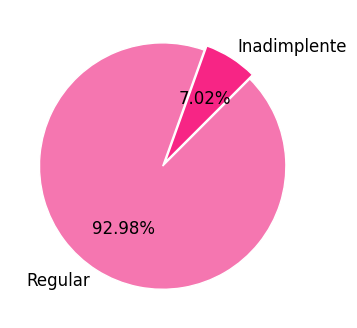

In [35]:
plt.figure(figsize=(4, 4))
plt.pie([len(data.loc[data.INADIMPLENTE == 1]), 
         len(data.loc[data.INADIMPLENTE == 0])],
        labels=['Inadimplente', 'Regular'],
        colors=['#f72585', '#f576b0'],
        explode=(0.02, 0.02),
        startangle=45,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': "white"},
        textprops={'fontsize': 12});

## <div style="color:white;display:fill;border-radius:5px;background-color:#3f37c9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Inadimplencia por Pagamento</p></div>

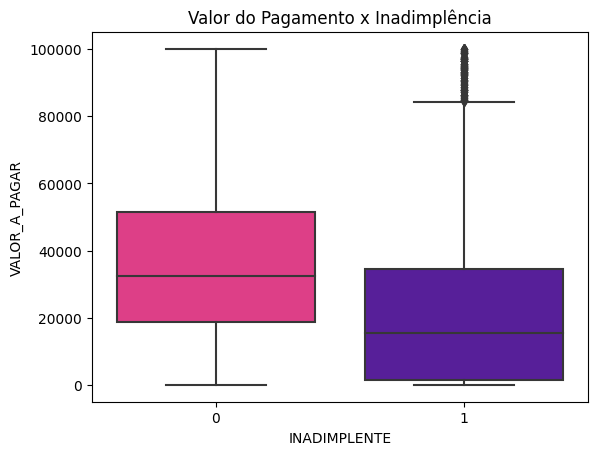

In [36]:
plt.title("Valor do Pagamento x Inadimplência")
sns.boxplot(data=data.loc[data.VALOR_A_PAGAR<=100_000], x="INADIMPLENTE", y="VALOR_A_PAGAR")
plt.show()

**Observação**

Foi considerado apenas valores a pagar menores que $100000.00, para facilitar a vizualição

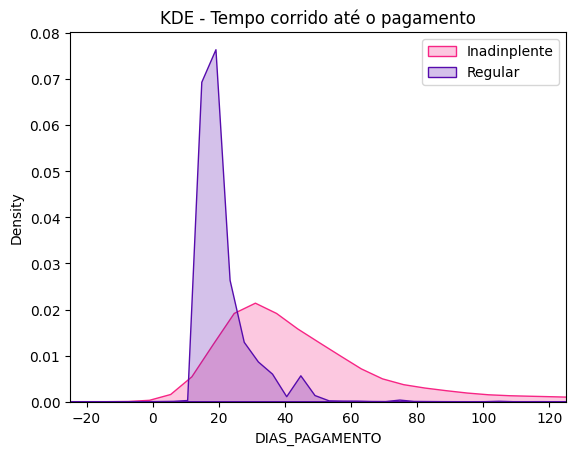

In [37]:
plt.title('KDE - Tempo corrido até o pagamento')
sns.kdeplot(data=data.loc[(data.INADIMPLENTE == 1)], x='DIAS_PAGAMENTO', fill=True, label='Inadinplente')
sns.kdeplot(data=data.loc[(data.INADIMPLENTE == 0)], x='DIAS_PAGAMENTO', fill=True, label='Regular')
plt.xlim(-25,125)
plt.legend(ncol=1, loc="upper right", frameon=True);

## <div style="color:white;display:fill;border-radius:5px;background-color:#3f37c9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Inadimplencia por Tempo</p></div>

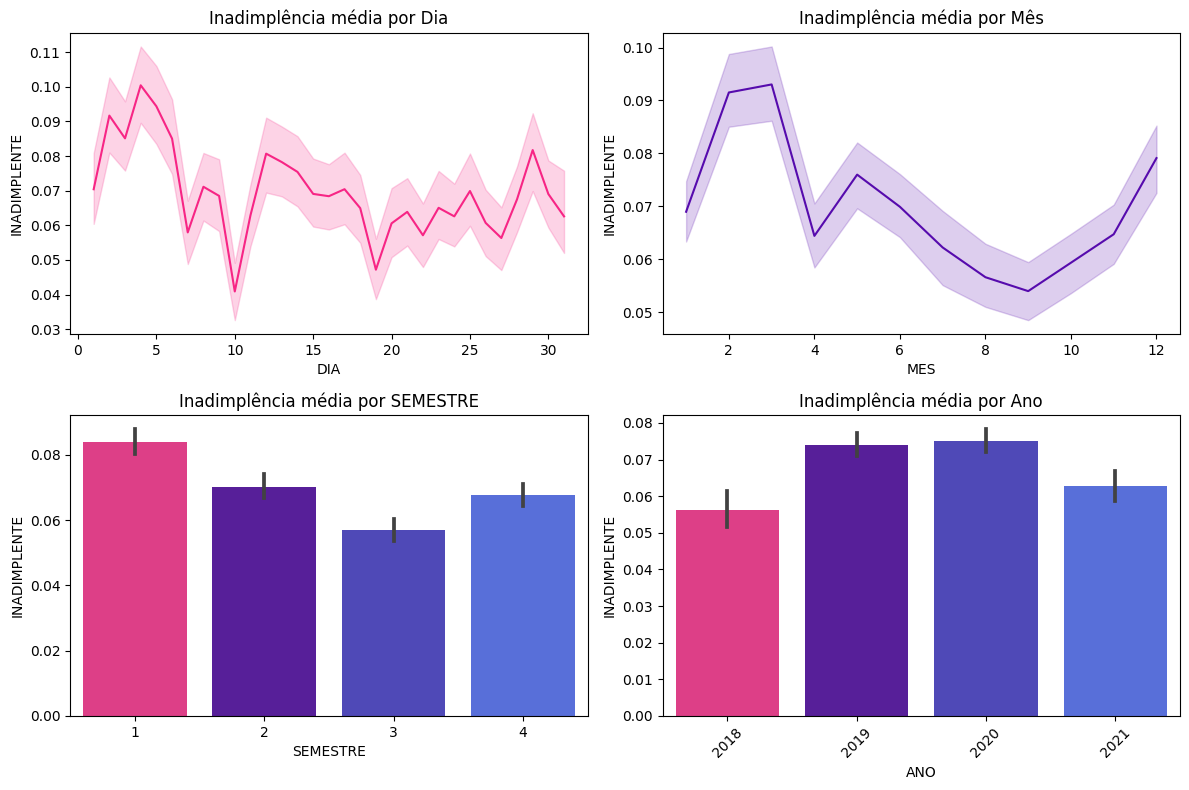

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.lineplot(data=data, x="DIA", y="INADIMPLENTE")
plt.title("Inadimplência média por Dia")

plt.subplot(2, 2, 2)
sns.lineplot(data=data, x="MES", y="INADIMPLENTE", color='#560bad')
plt.title("Inadimplência média por Mês")

plt.subplot(2, 2, 3)
sns.barplot(data=data, x="SEMESTRE", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média por SEMESTRE")

plt.subplot(2, 2, 4)
sns.barplot(data=data, x="ANO", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média por Ano")
plt.xticks(rotation=45)

plt.tight_layout();

### Analises

Existem meses e anos piores/melhores com relação a inadimplencia. O mês e o ano neste gráfico são relativos a data da emissão do documento de aprovação do crédito.

## <div style="color:white;display:fill;border-radius:5px;background-color:#3f37c9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Inadimplencia por Região</p></div>


Guia dos CEPs no Brasil: https://ajuda.mercos.com/hc/pt-br/articles/4402031115291-Faixas-de-CEP-por-Estado

In [39]:
aux_sudeste = data[['CEP_2_DIG','INADIMPLENTE']].loc[(data.CEP_2_DIG>=10) & (data.CEP_2_DIG<40)]
aux_nordeste = data[['CEP_2_DIG','INADIMPLENTE']].loc[(data.CEP_2_DIG>=40) & (data.CEP_2_DIG<66)]
aux_centro_norte = data[['CEP_2_DIG','INADIMPLENTE']].loc[(data.CEP_2_DIG>=66) & (data.CEP_2_DIG<80)]
aux_sul = data[['CEP_2_DIG','INADIMPLENTE']].loc[(data.CEP_2_DIG>=80) & (data.CEP_2_DIG<100)]

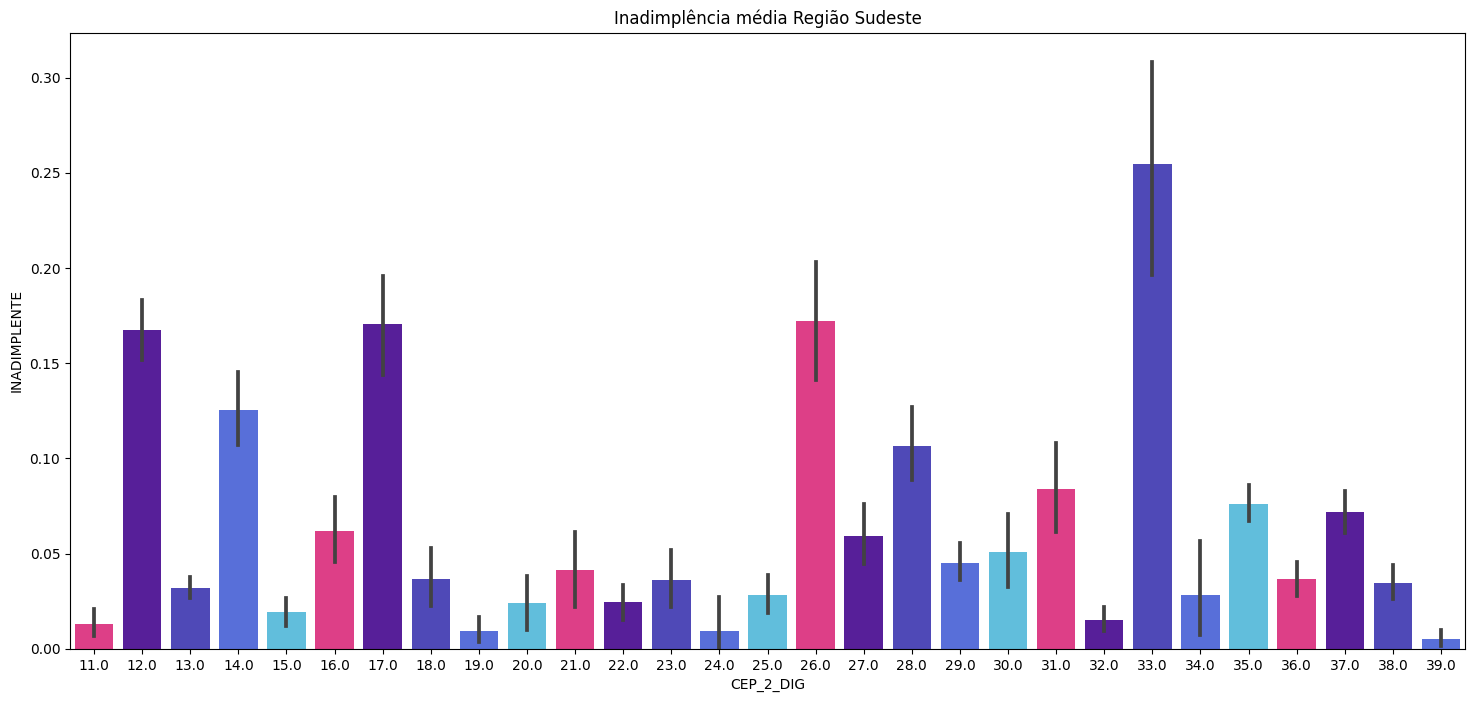

0    30183
1     1976
Name: INADIMPLENTE, dtype: int64
0    0.938555
1    0.061445
Name: INADIMPLENTE, dtype: float64


In [40]:
plt.figure(figsize=(18,8))
sns.barplot(data=aux_sudeste, x="CEP_2_DIG", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média Região Sudeste")
plt.show()
print(aux_sudeste.INADIMPLENTE.value_counts())
print(aux_sudeste.INADIMPLENTE.value_counts(normalize=True))

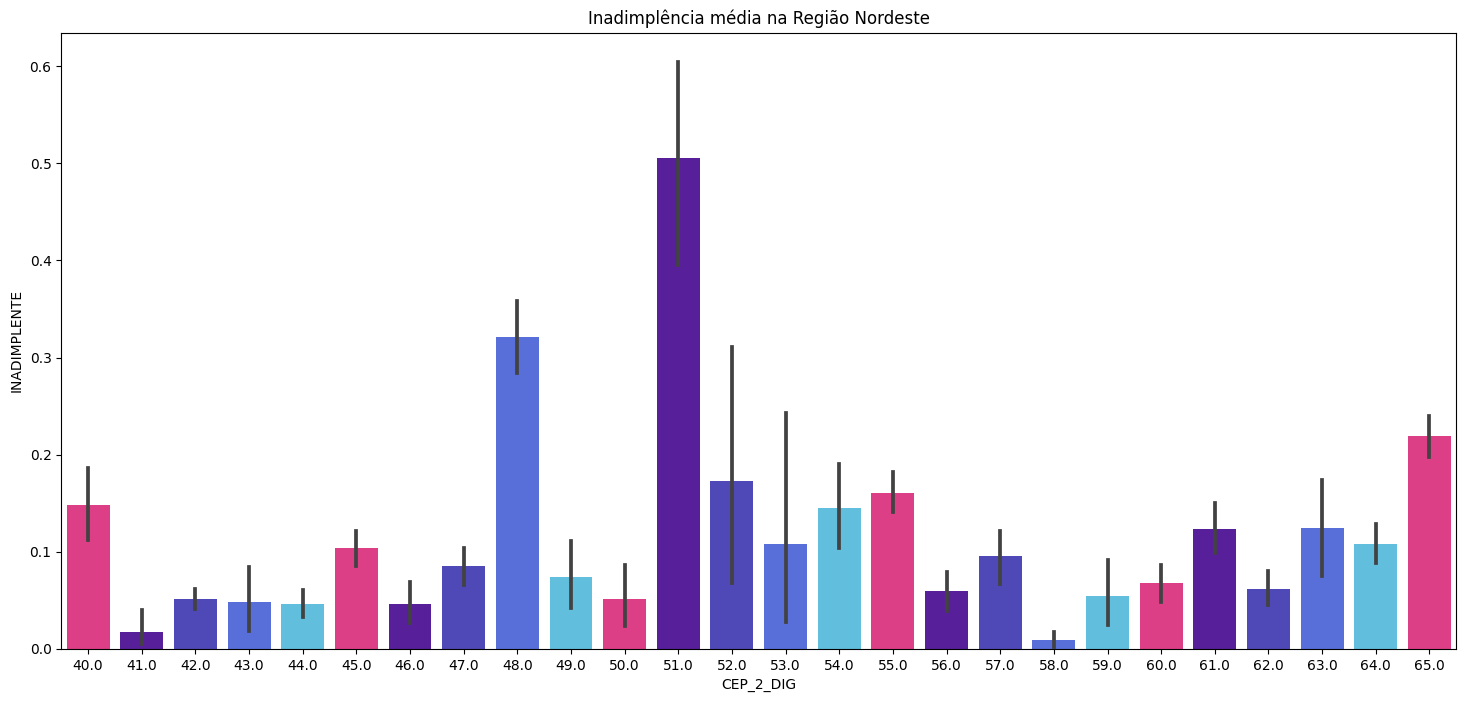

0    12270
1     1520
Name: INADIMPLENTE, dtype: int64
0    0.889775
1    0.110225
Name: INADIMPLENTE, dtype: float64


In [41]:
plt.figure(figsize=(18,8))
sns.barplot(data=aux_nordeste, x="CEP_2_DIG", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média na Região Nordeste")
plt.show()
print(aux_nordeste.INADIMPLENTE.value_counts())
print(aux_nordeste.INADIMPLENTE.value_counts(normalize=True))

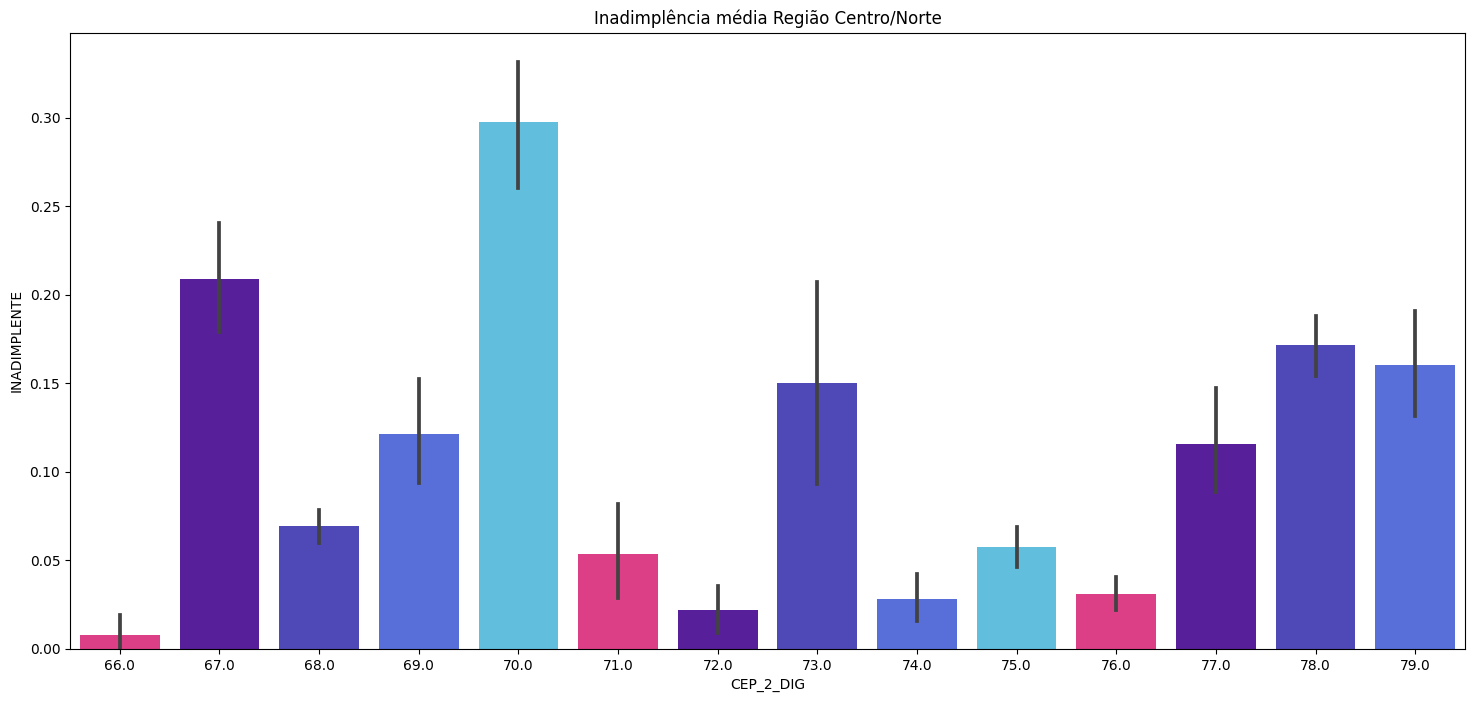

0    11034
1     1292
Name: INADIMPLENTE, dtype: int64
0    0.895181
1    0.104819
Name: INADIMPLENTE, dtype: float64


In [42]:
plt.figure(figsize=(18,8))
sns.barplot(data=aux_centro_norte, x="CEP_2_DIG", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média Região Centro/Norte")
plt.show()
print(aux_centro_norte.INADIMPLENTE.value_counts())
print(aux_centro_norte.INADIMPLENTE.value_counts(normalize=True))

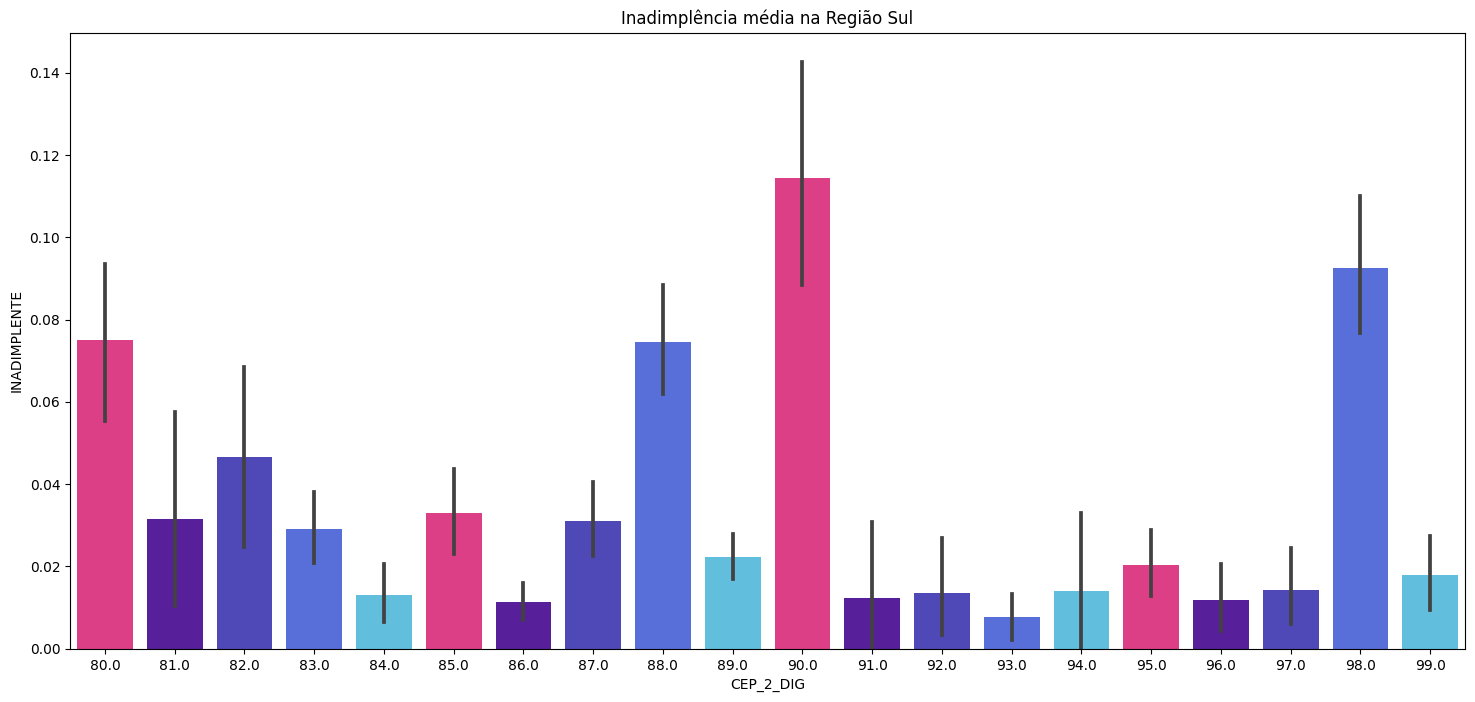

0    18491
1      648
Name: INADIMPLENTE, dtype: int64
0    0.966142
1    0.033858
Name: INADIMPLENTE, dtype: float64


In [43]:
plt.figure(figsize=(18,8))
sns.barplot(data=aux_sul, x="CEP_2_DIG", y="INADIMPLENTE", palette=CUSTOM_PALETTE)
plt.title("Inadimplência média na Região Sul")
plt.show()
print(aux_sul.INADIMPLENTE.value_counts())
print(aux_sul.INADIMPLENTE.value_counts(normalize=True))

### Analises

- A região sul do país é a que apresenta a menor média de inadimpência do país e a região nordeste a maior média de inadimplencia do país. 

- O CEP com a maior média de inadimplência é o "51" do Estado Pernambuco ( obs: não é o único CEP que compõe o Estado).

## <div style="color:white;display:fill;border-radius:5px;background-color:#3f37c9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Resume Customers</p></div>

In [44]:
last_day = df.DATA_EMISSAO_DOCUMENTO.max() + timedelta(days = 1)

transactions = df.groupby('ID_CLIENTE').agg(
                                        ina_media = ('INADIMPLENTE', np.mean),
                                        segmento=('SEGMENTO_INDUSTRIAL', lambda x: x.mode()[0]),
                                        freq = ('ID_CLIENTE', 'count'),                                        
                                        recencia = ('DATA_EMISSAO_DOCUMENTO', lambda x: ((last_day - x.max()).days)),
                                        #valor_max=('VALOR_A_PAGAR', np.max),
                                        valor_medio=('VALOR_A_PAGAR', np.mean),        
                                        valor_agregado =('VALOR_A_PAGAR', np.sum),
                                        funcionarios = ('NO_FUNCIONARIOS', np.mean),
                                        renda_media = ('RENDA_MES_ANTERIOR', np.mean),                                       
                                        #mes_freq=('MES', lambda x: x.mode()[0]),                                        
                                        cep=('CEP_2_DIG', lambda x: x.mode()[0]),
                                        tempo_cliente = ('DIAS_CADASTRADO', np.max),
                                        dias_debito_media = ('DIAS_DEBITO', np.mean),
                                        ).reset_index()

In [45]:
most_ina = transactions.sort_values(by=['ina_media','freq','valor_agregado'], ascending =False).head(10).set_index('ID_CLIENTE')

most_ina.valor_medio = most_ina.valor_medio.round(2)
most_ina.renda_media = most_ina.renda_media.round(2)
most_ina.funcionarios = most_ina.funcionarios.round(0)
most_ina.dias_debito_media = most_ina.dias_debito_media.round(0)

print("Top 10 Inadimplente ordenados pela inadimplencia média, frequencia aprovação de crédito e valor somado das solicitações aprovada")
most_ina

Top 10 Inadimplente ordenados pela inadimplencia média, frequencia aprovação de crédito e valor somado das solicitações aprovada


,ina_media,segmento,freq,recencia,valor_medio,valor_agregado,funcionarios,renda_media,cep,tempo_cliente,dias_debito_media
ID_CLIENTE,,,,,,,,,,,
43266641219008038,1.0,Serviços,9,364,19391.68,174525.14,94.0,124485.47,36.0,136,33.0
8594897944068249710,1.0,Serviços,7,742,8896.14,62273.00,127.0,96747.26,74.0,449,31.0
9099218788416728596,1.0,Indústria,4,22,5048.36,20193.45,140.0,97071.30,50.0,58,17.0
7204322229254419755,1.0,Serviços,3,477,950000.00,2850000.00,108.0,75519.87,80.0,4873,33.0
4442205629227031623,1.0,Comércio,3,830,87666.67,263000.00,118.0,113366.60,44.0,2198,166.0
1462395707491634845,1.0,Comércio,3,577,15393.86,46181.57,116.0,282996.00,88.0,2317,6.0
2218664010734431754,1.0,Indústria,3,687,11953.07,35859.21,99.0,146965.87,58.0,484,16.0
4853303856126909724,1.0,Indústria,3,4,5215.52,15646.55,118.0,113366.60,99.0,34,6.0
8846153146417722343,1.0,Indústria,3,603,4759.08,14277.25,110.0,296537.53,59.0,7022,10.0


### Analise

Esse tipo de tabela é comumente utilizado em projetos de segmentação de clientes que podem ser usados também para atribuir um "Score" para cada cliente de acordo com seu cluster. É possivel perceber também o quão custoso clietnes inadimplêntes podem ser.

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation</p></div>

In [46]:
data_prep = df.copy()
data_prep.shape

(77414, 24)

In [47]:
data_prep.isna().sum().sum()

0

In [48]:
data_prep.columns

Index(['ID_CLIENTE', 'DATA_CADASTRO', 'DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG', 'SAFRA_REF',
       'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'DATA_EMISSAO_DOCUMENTO',
       'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA',
       'DIAS_DEBITO', 'INADIMPLENTE', 'DIAS_CADASTRADO', 'DIAS_VENCIMENTO',
       'ANO', 'SEMESTRE', 'MES', 'DIA'],
      dtype='object')

In [49]:
NUMERICAL = ['DDD', 'FLAG_PF', 'CEP_2_DIG', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS','VALOR_A_PAGAR', 'TAXA', 'DIAS_CADASTRADO', 'DIAS_VENCIMENTO', 'ANO', 'SEMESTRE', 'MES', 'DIA']
CATEGORICAL = ['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL']

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Encoding</p></div>

In [50]:
def Encoding(df: pd.DataFrame):
    
    ## CATEGORICAL FEATURES
    segment_dict = {'Desconhecido': -1,'Pessoa Fisica': 0, 'Serviços': 1,  'Comércio': 2, 'Indústria':3}
    df['SEGMENTO_INDUSTRIAL'] = df['SEGMENTO_INDUSTRIAL'].map(segment_dict)

    porte_dict = {'PEQUENO': 1,  'MEDIO':2, 'GRANDE':3}
    df['PORTE'] = df['PORTE'].map(porte_dict)

    email_dict = {'DESCONHECIDO': -1, 'BOL': 1, 'AOL': 2,  'OUTLOOK': 3, 'HOTMAIL':4, 'YAHOO':5, 'GMAIL':6}
    df['DOMINIO_EMAIL'] = df['DOMINIO_EMAIL'].map(email_dict)
    
    return df

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Base Features</p></div>

Existem algumas features que não serão usadas:

**ID_CLIENTE:** Queremos fazer a predição a partir das caracteristicas, não queremos infor 

**DATA_CADASTRO, SAFRA_REF, DATA_EMISSAO_DOCUMENTO, DATA_PAGAMENTO:** Formatos como textos e datas não são usados

**DATA_PAGAMENTO, DIAS_DEBITO:** Data Leakage

**DDD:** Possui muitos valores faltantes, alem do mais possui um significado muito proximo do CEP_2_DIG

**FLAG_PF:** Como visto nas etapas anteriores esse valor foi incorporado no SEGMENTO_INDUSTRIAL

**PORTE:** Parece que o porte das empresas está mal definido...

In [51]:
def BaseFeatures():
    
    FEATURES = ['VALOR_A_PAGAR',
                'TAXA',
                'RENDA_MES_ANTERIOR',
                'NO_FUNCIONARIOS',
                'SEGMENTO_INDUSTRIAL',
                'DOMINIO_EMAIL',
                'CEP_2_DIG',
                'DIAS_CADASTRADO',
                'DIAS_VENCIMENTO',
                'ANO',
                #'SEMESTRE', foi pouco relevante para o modelo 
                'MES',
                #'DIA' foi pouco relevante para os modelo
               ]

    TARGET = 'INADIMPLENTE'    
    
    return FEATURES, TARGET

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Outliers</p></div>

In [52]:
exemplo = df.copy()

In [53]:
exemplo = Encoding(exemplo)
FEATURES, TARGET = BaseFeatures()

In [54]:
# %%time
# sns.pairplot(outliers, vars=FEATURES, hue='anomaly', palette=["#f72585", "#560bad"])

In [55]:
def Outliers(df: pd.DataFrame, features: list, contamination=0.02, verbose=False, plot=False):
    
    '''
    Incorporar ao codigo todos os dados que são "não outliers" e os dados que são outliers mas são
    "não inadimplentes", já que não queremos ter menos dados de inadimplente na base de dados de treino
    
    Contaminação default de 0.02% do dataset, para detecção de outliers com o IsolationForest
    
    '''
    
    isfo = IsolationForest(contamination=contamination, random_state = RANDOM_SEED)
    isfo.fit(df[features])
    df['anomaly_score'] =  isfo.decision_function(df[features])
    df['anomaly'] = isfo.predict(df[features])
    
    
    if verbose==True:    
        print("Linhas com outliers:", df[df['anomaly'] == -1].shape[0])
        print("Linhas sem outliers", df[df['anomaly'] == 1].shape[0])
        print("\nTotal Regulares(0)/Inadimplentes(1) considerados somente os não Outliers:\n", df.INADIMPLENTE[df['anomaly'] == 1].value_counts())
        print("\nTotal Regulares(0)/Inadimplentes(1) considerados somente os Outliers:\n", df.INADIMPLENTE[df['anomaly'] == -1].value_counts())

    if plot==True:
        ## Esse plot demora uns 7min para carregar ele mostra a combinação de todas as colunas
        sns.pairplot(outliers, vars=FEATURES, hue='anomaly', palette=["#f72585", "#560bad"])
        
    df = df.loc[(df['anomaly'] == 1) | ((df['anomaly'] == -1) & (df['INADIMPLENTE'] == 1))]
    df = df.drop(columns=['anomaly','anomaly_score'], axis=1)
    
    return df

In [56]:
exemplo = Outliers(exemplo, FEATURES, verbose=True)

X does not have valid feature names, but IsolationForest was fitted with feature names


Linhas com outliers: 1549
Linhas sem outliers 75865

Total Regulares(0)/Inadimplentes(1) considerados somente os não Outliers:
 0    70671
1     5194
Name: INADIMPLENTE, dtype: int64

Total Regulares(0)/Inadimplentes(1) considerados somente os Outliers:
 0    1307
1     242
Name: INADIMPLENTE, dtype: int64


In [57]:
exemplo.shape, df.shape

((76107, 24), (77414, 24))

**Observações**

Fiz alguns teste para remover alguns poucos outliers para talvez melhorar o modelo, mas não obtive nenhum ganho significativo... Essa parte do código está mais para efeito ilustrativo, a solução final não incluí tratamento de outliers.

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Normalization</p></div>

In [58]:
def Normalization(df: pd.DataFrame, features: list, verbose=False, plot=False):
    
    log_columns = df[features].skew(numeric_only=True)
    log_columns = log_columns.loc[log_columns > 0.75]
    
    if verbose==True:
        print('Colunas que serão aplicados log1p e seu skewness:\n', log_columns)
        
    if plot==True: 
        print('Features antes de aplicar a função log')
        df[features].hist(figsize=(18,15), bins='auto');    
    
    for col in log_columns.index:
        if (df[col] >= 0).all():
            df[col] = np.log1p(df[col])
    
    return df

In [59]:
def Standardization(df: pd.DataFrame, features: list):
    
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    
    return df

Colunas que serão aplicados log1p e seu skewness:
 VALOR_A_PAGAR         17.557395
TAXA                   1.630629
RENDA_MES_ANTERIOR     1.388411
DIAS_VENCIMENTO       12.179737
dtype: float64
Features antes de aplicar a função log


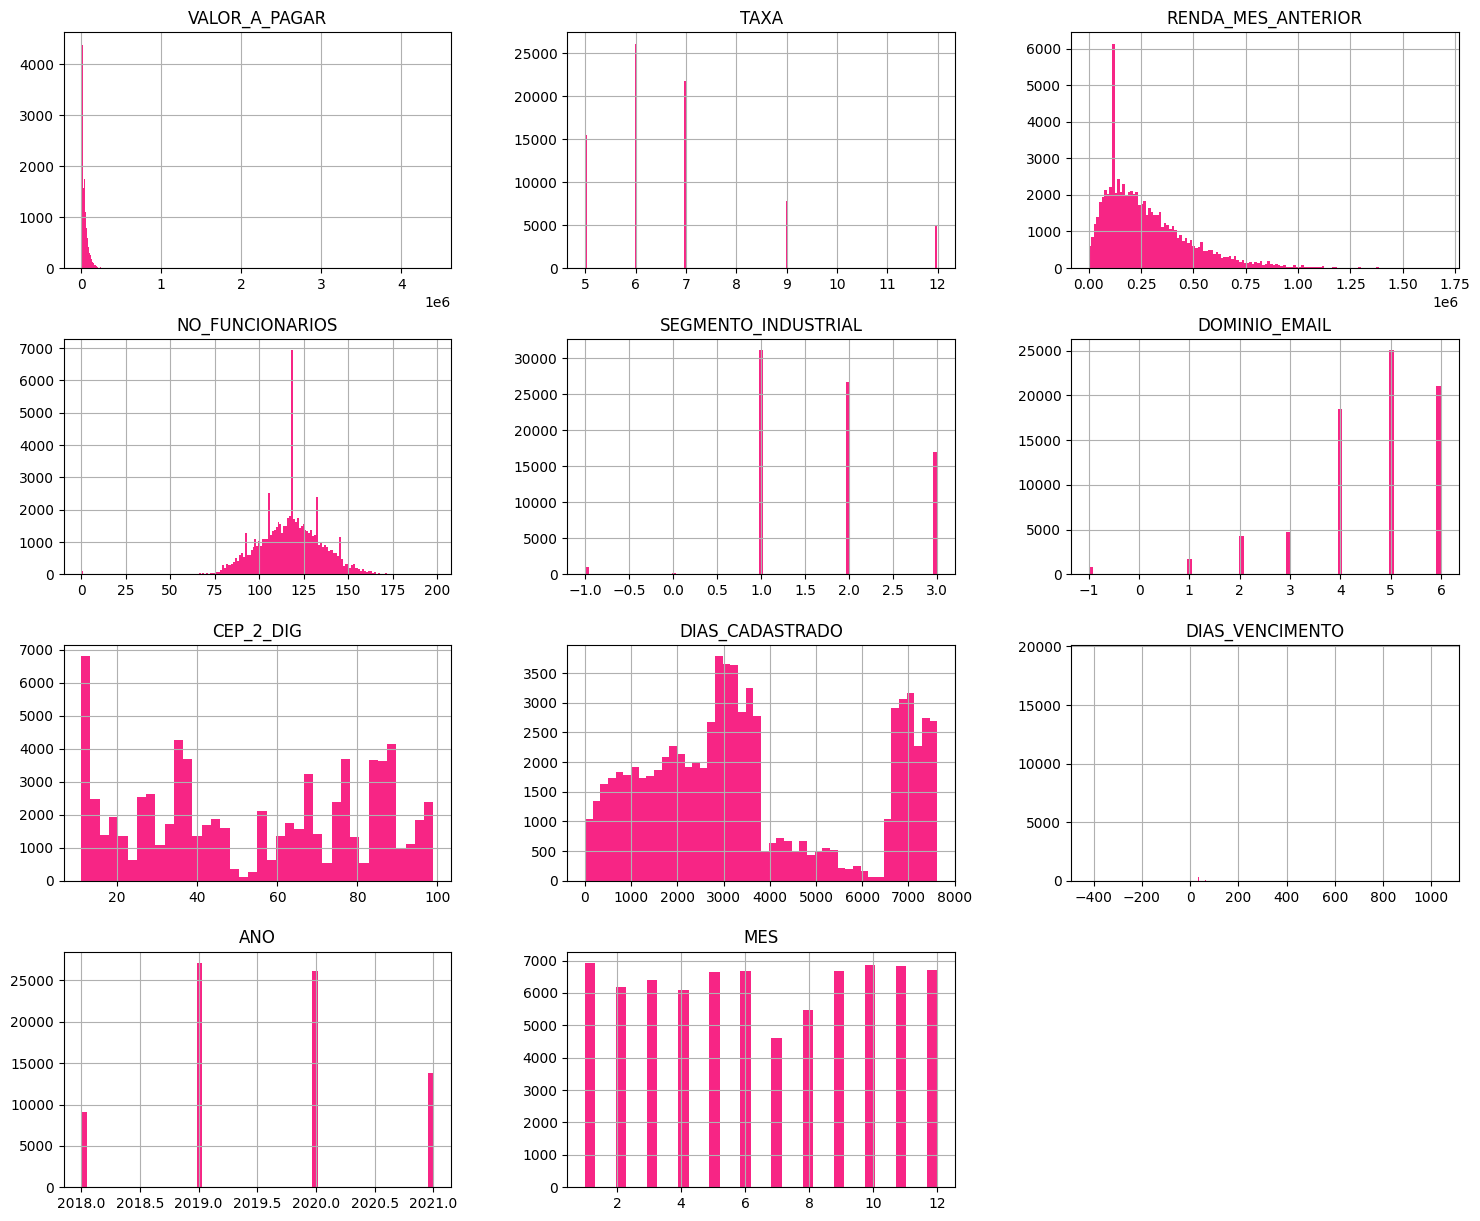

In [60]:
exemplo = Normalization(exemplo, FEATURES, verbose=True, plot=True)

**Obeservações**

Pelo fato dos modelos apresentados no notebook serem baseados em árvores de decisão e o problema ser de classificação a normalização acaba que nem faz diferença, essa etapa está mais para efeito ilustrativo, não será implementada na solução final.

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Data Preparation Pipeline</p></div>

In [61]:
def Preparation(df: pd.DataFrame, outliers=False, norm=False, scale=False):
  
    df = Encoding(df)
    FEATURES, TARGET = BaseFeatures()
    
    if outliers==True:
        df = Outliers(df, FEATURES)
    
    if norm ==True:
        df = Normalization(df, FEATURES)
        
    if scale ==True:
        df = Standardization(df, FEATURES)
    
    return  df, FEATURES, TARGET

In [62]:
data_prep, FEATURES, TARGET = Preparation(df, outliers=False, norm=False, scale=False)

In [63]:
data_prep.isna().sum().sum()

0

In [64]:
X = data_prep[FEATURES]
y = data_prep[TARGET]

In [65]:
X.shape, y.shape, df.shape

((77414, 11), (77414,), (77414, 24))

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Machine Learning Models</p></div>

### Premissas do Modelo:
- A métrica escolhida para analise de performasse do modelo foi o **Recall**, pois é uma métrica boa para se trabalhar com dados desbalanceados e em problemas como o de inadimplência, já que **o pior cenário é conceder crédito para alguem inadimplente** do que negar crédito para um pagador regular.
- Como não foi estipulado nenhum nivel de performace satisfatório minima para o modelo, **cabe a comissão técnica de avaliadores determinar o sucesso do modelo**.
- Neste projeto foram utilizados o **LightGBM** e o **XGBoost** que são dois dos melhores frameworks para construção de modelos de Machine Learning para dados tabulares. Fiz alguns testes com o pytorch mas o modelo desempenhou abaixo dos dois, então para não deixar o notebook maior do que já está decidi não incluir no projeto.

In [66]:
def ConfusionMatrix(y, y_pred):
    
    labels = ["Regular", "Inadimplente"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Purples", values_format="d")  
    plt.show()
    print("Score: \n", classification_report(y,y_pred))  

In [67]:
def CrossValidationPredict(model, X, y, number_folds = 3, threshold=0.5):   
     
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)    
    y_prob = cross_val_predict(model, X, y, cv=Kfold, method='predict_proba', verbose=False)    
    y_prob = y_prob[:, 1]
    y_pred = np.where(y_prob >= threshold, 1, 0)   
    ConfusionMatrix(y,y_pred)
    
    return y_prob, y_pred

In [68]:
def CrossValidationScore(model, X, y, number_folds = 3):    
       
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)
    scores = cross_validate(model, X, y, cv = Kfold, scoring=['accuracy','precision','recall','f1','roc_auc'], return_train_score=True)
    df = pd.DataFrame.from_dict(scores).T
    df['value'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    display(df[['value','std']])
    
    return df[['value','std']]

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [69]:
#Default Values of LGBMClassifier
lgbm_model = LGBMClassifier(random_state=RANDOM_SEED)

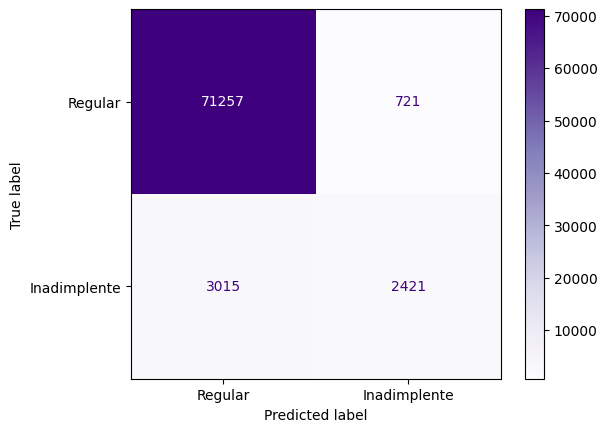

Score: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     71978
           1       0.77      0.45      0.56      5436

    accuracy                           0.95     77414
   macro avg       0.86      0.72      0.77     77414
weighted avg       0.95      0.95      0.95     77414



In [70]:
lgbm_prob, lgbm_pred  = CrossValidationPredict(lgbm_model,X,y)

In [71]:
lgbm_scores  = CrossValidationScore(lgbm_model,X,y)

,value,std
fit_time,0.102547,0.004358
score_time,0.039619,0.000516
test_accuracy,0.952425,0.000241
train_accuracy,0.961635,0.000471
test_precision,0.779833,0.004871
train_precision,0.868658,0.005453
test_recall,0.449411,0.005881
train_recall,0.534584,0.012394
test_f1,0.570172,0.004047
train_f1,0.661720,0.007875


## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGboost</p></div>

In [72]:
#Default Values of XGBClassifier
xgb_model = XGBClassifier(random_state=RANDOM_SEED)

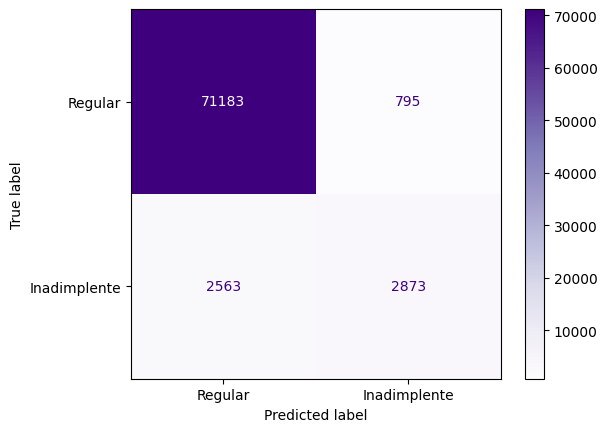

Score: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     71978
           1       0.78      0.53      0.63      5436

    accuracy                           0.96     77414
   macro avg       0.87      0.76      0.80     77414
weighted avg       0.95      0.96      0.95     77414



In [73]:
xgb_prob, xgb_pred = CrossValidationPredict(xgb_model, X, y)

In [74]:
xgb_scores  = CrossValidationScore(xgb_model, X, y)

,value,std
fit_time,1.399870,0.079746
score_time,0.037672,0.002875
test_accuracy,0.955964,0.000614
train_accuracy,0.974772,0.000332
test_precision,0.772374,0.005315
train_precision,0.923002,0.000330
test_recall,0.528698,0.007700
train_recall,0.699043,0.005110
test_f1,0.627692,0.006448
train_f1,0.795551,0.003323


# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Hypertunning</p></div> 

Serão testados os principais parametros para o LightGBM e o XGBoost, o objetivo principal é retornar o melhor recall usando com um tempo de execução não tão alto.

In [75]:
#Variavel para lidar com os dados deslanceados, util para o LightGBM e XGBoost
weight = round(float((y.value_counts()[0])/(y.value_counts()[1])),3) #sum_neg/sum_p
weight

13.241

## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">LightGBM</p></div>

In [76]:
def objective(trial):
      
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary']),
        'metric': trial.suggest_categorical('metric', ['auc','binary_logloss']), 
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']), 
        'num_leaves': trial.suggest_int('num_leaves', 30, 120, step=10),
        'max_depth': trial.suggest_int('max_depth', 6, 15, 1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e-2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-2, log=True),
        'boost_from_average': trial.suggest_categorical('boost_from_average', [False,True]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED])}
    
    model = LGBMClassifier(**param_grid)
    
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True)
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    return recall_score(y,y_pred)  

In [77]:
%%time
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING); 
#optuna.logging.set_verbosity(optuna.logging.DEBUG);
study.optimize(objective, n_trials=200);

trial = study.best_trial

# Os trials foram ocultados para não poluir a vizualização do notebook

[I 2023-06-22 14:51:43,462] A new study created in memory with name: no-name-8fc566f0-523f-4ac7-b9c1-c51211084335


CPU times: user 39min 29s, sys: 5.75 s, total: 39min 35s
Wall time: 3min 34s


In [78]:
lgbm_best_params = study.best_params
lgbm_best_score = study.best_value
print(f"Best score: {lgbm_best_score}\n")
print(f"Optimized parameters: {lgbm_best_params}\n")

Best score: 0.8745401030169242

Optimized parameters: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 13, 'learning_rate': 0.04966178911998172, 'reg_alpha': 2.5175754487661697e-08, 'reg_lambda': 0.00019749644477048975, 'boost_from_average': True, 'scale_pos_weight': 13.241, 'seed': 42}



## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Checking Parameters</p></div>

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((61931, 11), (61931,), (15483, 11), (15483,))

In [80]:
def plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val):
    
    train_scores = []
    val_scores = []
    
    for param_value in param_range:
        params = fixed_params
        params[param_name] = param_value
        
        lgbm = LGBMClassifier(**params)
        lgbm.fit(X_train, y_train)
        
        train_scores.append(recall_score(y_train, lgbm.predict(X_train)))
        val_scores.append(recall_score(y_val, lgbm.predict(X_val)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(param_range, train_scores, label="Train", color="#560bad")
    plt.plot(param_range, val_scores, label="Val", color="#3f37c9")

    plt.title("LightGBM")
    plt.xlabel(param_name)
    plt.ylabel("Recall")
    plt.tight_layout()
    plt.legend(loc="best");

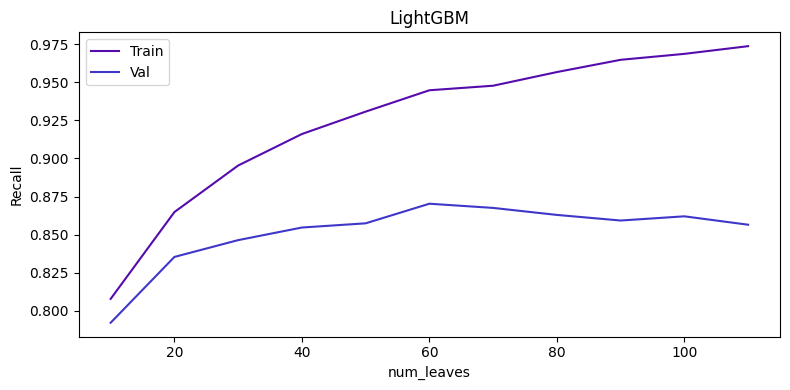

In [81]:
param_name = "num_leaves"
param_range = np.arange(10, 120, 10)
fixed_params = lgbm_best_params.copy()

plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

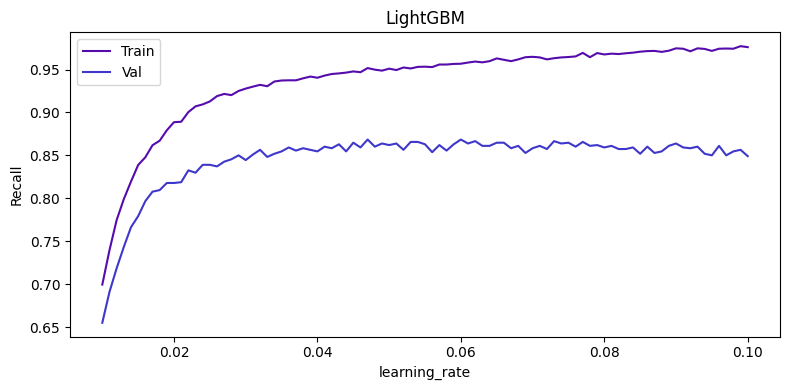

In [82]:
param_name = "learning_rate"
param_range = np.arange(0.01, 0.1, 0.001)
fixed_params = lgbm_best_params.copy()

plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

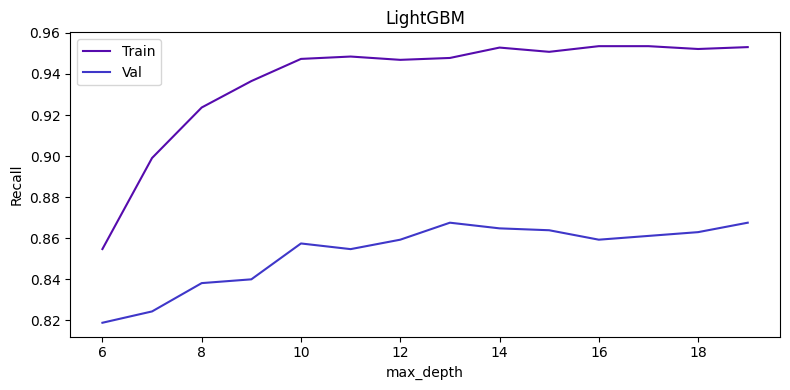

In [83]:
param_name = "max_depth"
param_range = np.arange(6, 20, 1)
fixed_params = lgbm_best_params.copy()

plot_lgbm_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

In [84]:
lgbm_best_params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'boosting_type': 'gbdt',
 'num_leaves': 70,
 'max_depth': 13,
 'learning_rate': 0.04966178911998172,
 'reg_alpha': 2.5175754487661697e-08,
 'reg_lambda': 0.00019749644477048975,
 'boost_from_average': True,
 'scale_pos_weight': 13.241,
 'seed': 42}

In [85]:
lgbm_best_params_revised = {'objective': 'binary',
                            'metric': 'binary_logloss',
                            'boosting_type': 'gbdt',
                            'num_leaves': 70,
                            'max_depth': 15,
                            'learning_rate': 0.05,
                            'reg_alpha': 5.00e-05,
                            'reg_lambda': 5.00e-05,
                            'boost_from_average': True,
                            'scale_pos_weight': 13.241,
                            'seed': 42}

In [86]:
lgbm_model_opt = LGBMClassifier(**lgbm_best_params_revised)

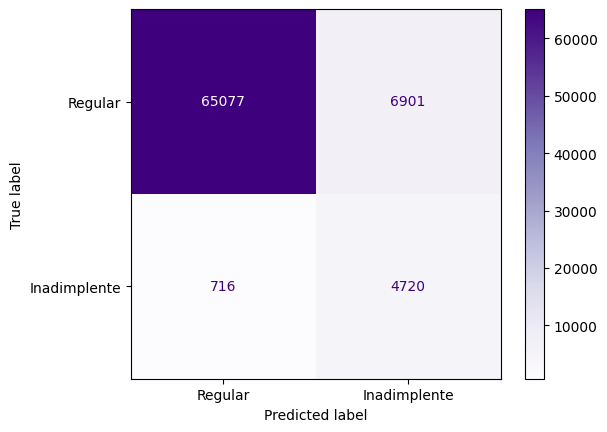

Score: 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     71978
           1       0.41      0.87      0.55      5436

    accuracy                           0.90     77414
   macro avg       0.70      0.89      0.75     77414
weighted avg       0.95      0.90      0.92     77414



In [87]:
lgbm_prob, lgbm_pred  = CrossValidationPredict(lgbm_model_opt,X,y, threshold=0.5)

In [88]:
lgbm_scores  = CrossValidationScore(lgbm_model_opt,X,y)

,value,std
fit_time,0.273984,0.029846
score_time,0.059634,0.005342
test_accuracy,0.902808,0.002439
train_accuracy,0.913885,0.001726
test_precision,0.409619,0.006232
train_precision,0.447231,0.005079
test_recall,0.868837,0.005432
train_recall,0.957873,0.001942
test_f1,0.556697,0.004649
train_f1,0.609740,0.004322


## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">XGBoost</p></div>

In [89]:
def objective(trial): 
    
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc','logloss']),
        'booster': trial.suggest_categorical('booster', ['gbtree','dart']),   
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 250, step=50),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-2, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1e-2, log=True),  
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [weight]),
        'seed': trial.suggest_categorical('seed', [RANDOM_SEED])}

    model = XGBClassifier(**param_grid)
    number_folds = 3
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True) #random_state=RANDOM_SEED
    y_pred = cross_val_predict(model, X, y, cv=Kfold)
    
    return recall_score(y,y_pred)

In [90]:
#%%time
study = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING) 
#optuna.logging.set_verbosity(optuna.logging.DEBUG) 
study.optimize(objective, n_trials=50) 

trial = study.best_trial

# Os trials foram ocultados para não poluir a vizualização do notebook

In [91]:
xgb_best_params = study.best_params
xgb_best_score = study.best_value
print(f"Best score: {xgb_best_score}\n")
print(f"Optimized parameters: {xgb_best_params}\n")

Best score: 0.8478660779985283

Optimized parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.059897948337313114, 'n_estimators': 250, 'alpha': 0.0012087560412890714, 'lambda': 3.624621830467397e-08, 'scale_pos_weight': 13.241, 'seed': 42}



## <div style="color:white;display:fill;border-radius:5px;background-color:#3F37C9;letter-spacing:0.5px;overflow:hidden"><p style="padding:15px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Checking Parameters</p></div>

In [92]:
def plot_xgb_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val):
    
    train_scores = []
    val_scores = []
    
    for param_value in param_range:
        params = fixed_params.copy()
        params[param_name] = param_value
        
        xgb = XGBClassifier(**params)
        xgb.fit(X_train, y_train)
        
        train_scores.append(recall_score(y_train, xgb.predict(X_train)))
        val_scores.append(recall_score(y_val, xgb.predict(X_val)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(param_range, train_scores, label="Train", color="#560bad")
    plt.plot(param_range, val_scores, label="Val", color="#3f37c9")

    plt.title("XGBoost")
    plt.xlabel(param_name)
    plt.ylabel("Recall")
    plt.tight_layout()
    plt.legend(loc="best");

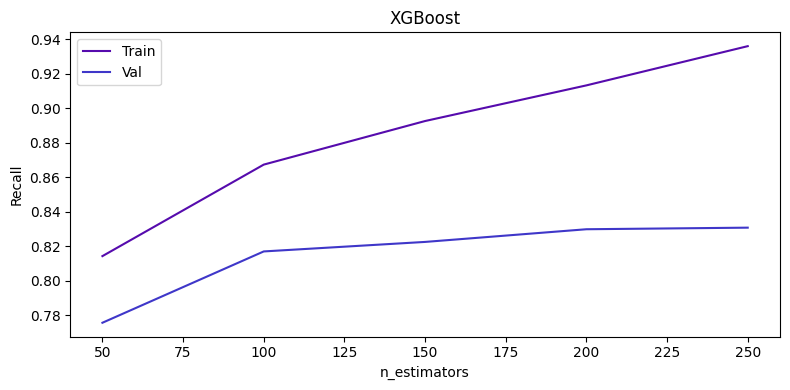

In [93]:
param_name = "n_estimators"
param_range = np.arange(50, 300, 50)
fixed_params = xgb_best_params.copy()

plot_xgb_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

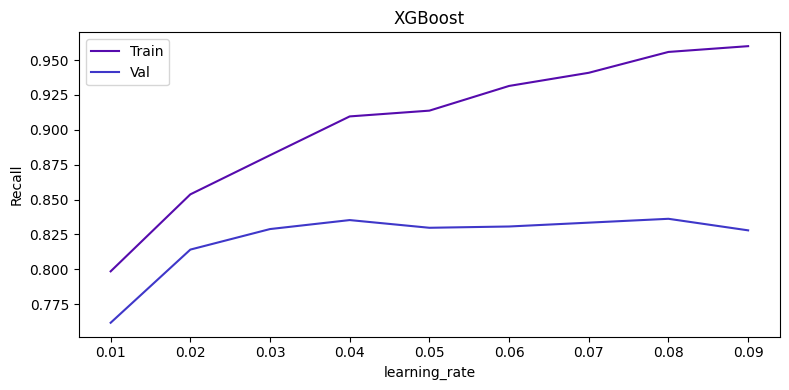

In [94]:
param_name = "learning_rate"
param_range = np.arange(0.01, 0.1, 0.01)
fixed_params = xgb_best_params.copy()

plot_xgb_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

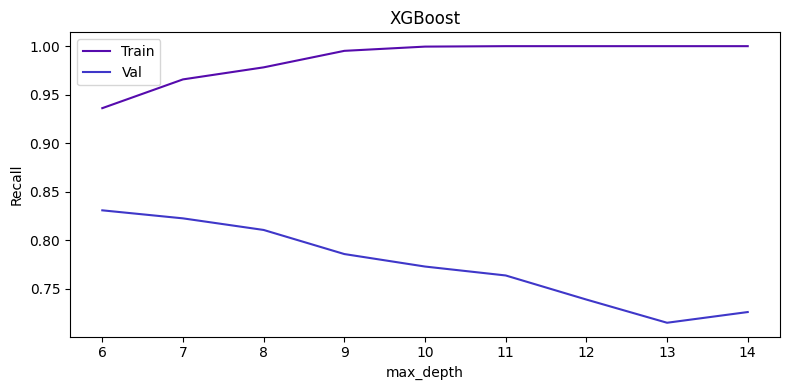

In [95]:
param_name = "max_depth"
param_range = np.arange(6, 15, 1)
fixed_params = xgb_best_params.copy()

plot_xgb_param_scores(param_name, param_range, fixed_params, X_train, y_train, X_val, y_val)

In [96]:
xgb_best_params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'booster': 'gbtree',
 'max_depth': 6,
 'learning_rate': 0.059897948337313114,
 'n_estimators': 250,
 'alpha': 0.0012087560412890714,
 'lambda': 3.624621830467397e-08,
 'scale_pos_weight': 13.241,
 'seed': 42}

In [97]:
xgb_best_params_revised = {'objective': 'binary:logistic',
                           'eval_metric': 'logloss',
                           'booster': 'gbtree',
                           'max_depth': 6,
                           'learning_rate': 0.08,
                           'n_estimators': 250,
                           'alpha': 1.20e-04,
                           'lambda': 3.75e-05,
                           'scale_pos_weight': 13.241,
                           'seed': RANDOM_SEED}

In [98]:
xgb_model_opt = XGBClassifier(**xgb_best_params_revised)

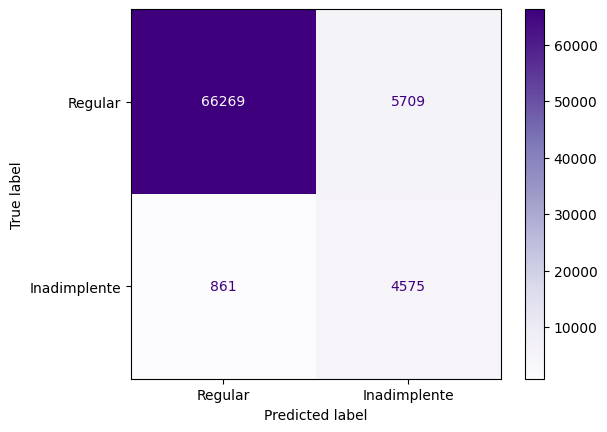

Score: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     71978
           1       0.44      0.84      0.58      5436

    accuracy                           0.92     77414
   macro avg       0.72      0.88      0.77     77414
weighted avg       0.95      0.92      0.93     77414



In [99]:
xgb_prob, xgb_pred  = CrossValidationPredict(xgb_model_opt,X,y, threshold=0.5)

In [100]:
xgb_scores  = CrossValidationScore(xgb_model_opt,X,y)

,value,std
fit_time,3.220175,0.061424
score_time,0.051868,0.000442
test_accuracy,0.914331,0.003101
train_accuracy,0.932086,0.002645
test_precision,0.442223,0.010654
train_precision,0.508889,0.010233
test_recall,0.839404,0.009311
train_recall,0.957046,0.004265
test_f1,0.579237,0.011137
train_f1,0.664425,0.009676


# <div style="color:white;display:fill;border-radius:5px;background-color:#4361ee;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Results</p></div> 

In [101]:
results = df.copy()

results['lgbm_prob'] = lgbm_prob
results['lgbm_pred'] = lgbm_pred
results['xgb_prob'] = xgb_prob
results['xgb_pred'] = xgb_pred

In [102]:
results[['ID_CLIENTE','SAFRA_REF','INADIMPLENTE','lgbm_prob', 'xgb_prob']]

,ID_CLIENTE,SAFRA_REF,INADIMPLENTE,lgbm_prob,xgb_prob
0,1661240395903230676,2018-08-01,0,0.505050,0.562360
1,1661240395903230676,2018-08-01,0,0.287298,0.328702
2,1661240395903230676,2018-08-01,0,0.298583,0.389003
3,1661240395903230676,2018-08-01,1,0.891017,0.893501
4,1661240395903230676,2018-08-01,0,0.338699,0.462392
...,...,...,...,...,...
77409,2951563549197799278,2021-06-01,0,0.011739,0.001662
77410,5220206408301580591,2021-06-01,0,0.589415,0.554880
77411,5860276371789140450,2021-06-01,0,0.172278,0.058778
77412,2814790209436551216,2021-06-01,0,0.205175,0.186366


In [103]:
#Considerando threshold = 0.5
recall_score(y, lgbm_pred), recall_score(y, xgb_pred)

(0.8682855040470935, 0.8416114790286976)

O **LightGBM** apresentou resultados um pouco melhores de Recall, além disso é um modelo mais leve portanto iremos será o modelo utilizado

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Explainability</p></div> 

In [104]:
aux = pd.concat([y, X], axis=1)

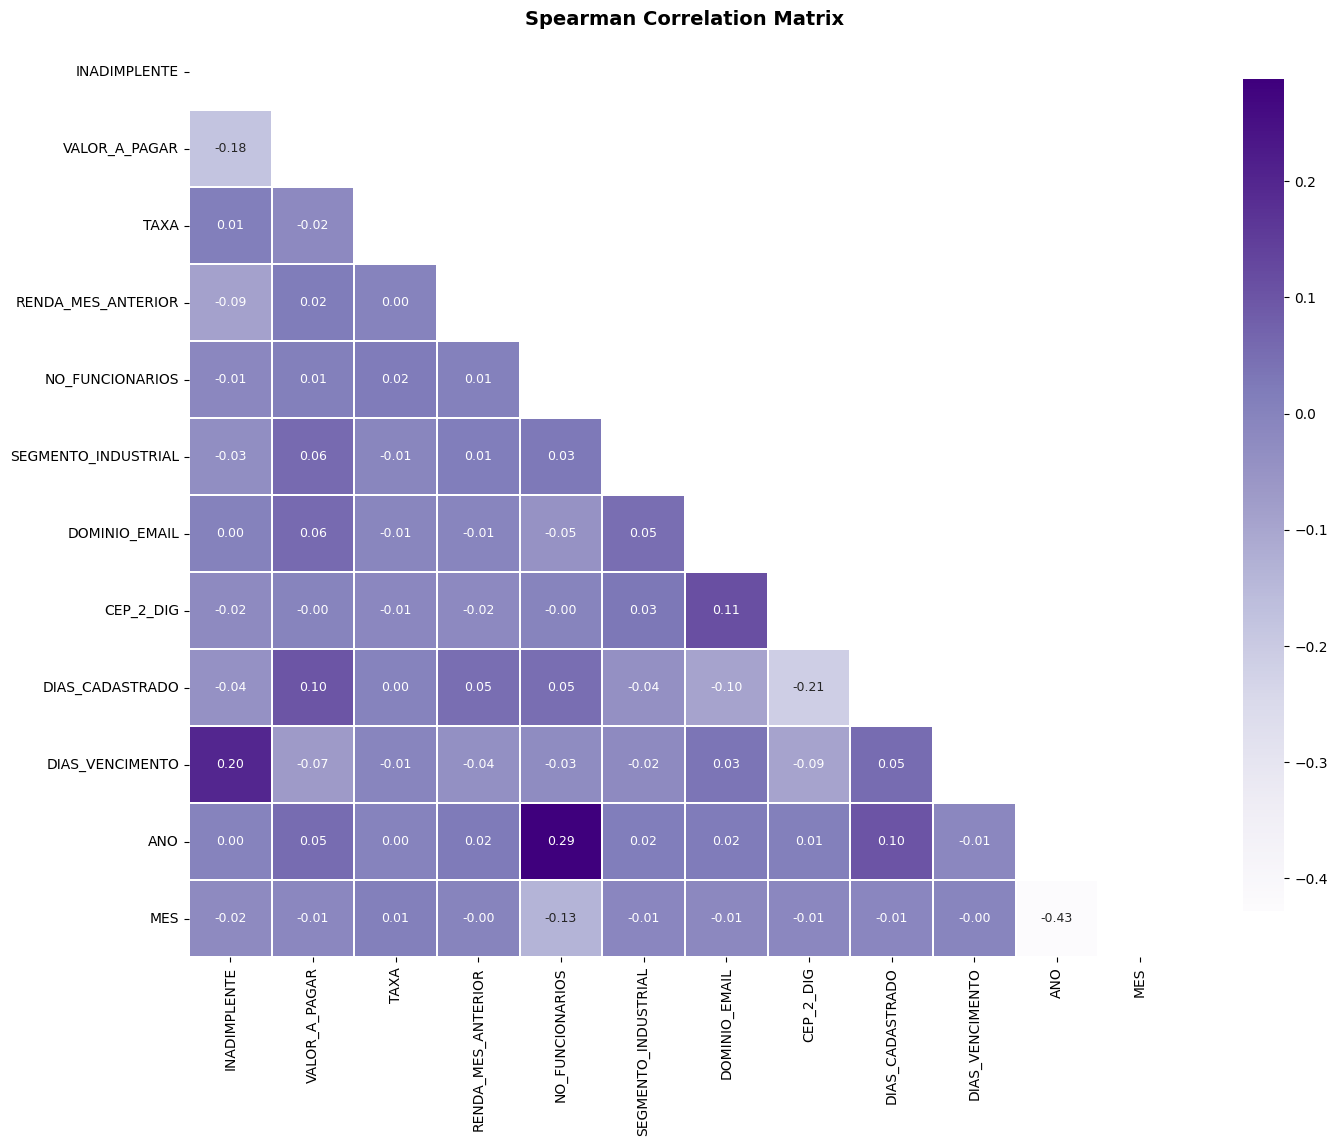

In [105]:
mask = np.zeros_like(aux.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Spearman Correlation Matrix',fontsize=14, fontweight='bold')
sns.heatmap(aux.corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Purples", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

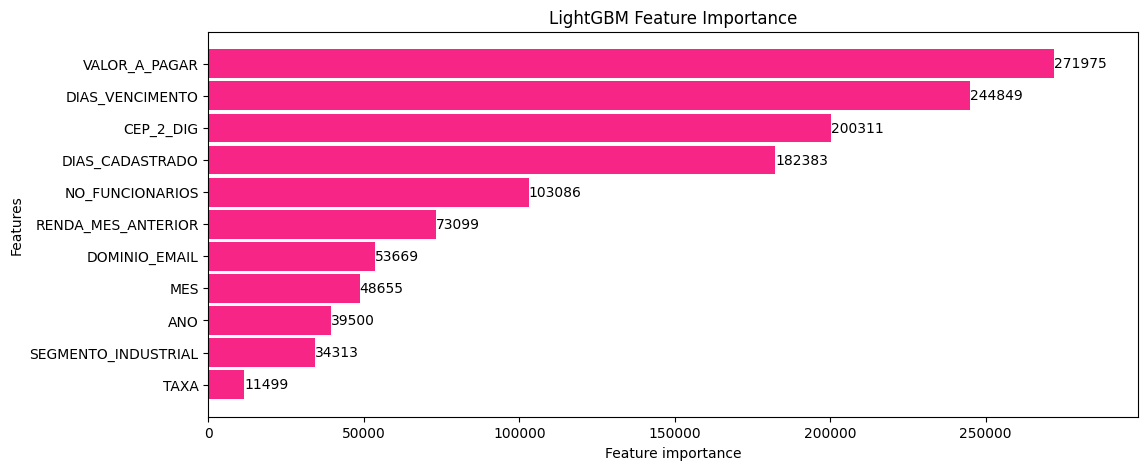

In [106]:
lgbm_model_opt.fit(X,y)

lightgbm.plot_importance(lgbm_model_opt, 
                         importance_type='gain', 
                         title= 'LightGBM Feature Importance', 
                         height=0.9, 
                         grid=False, 
                         precision=0, 
                         figsize=(12, 5), 
                         color='#f72585');

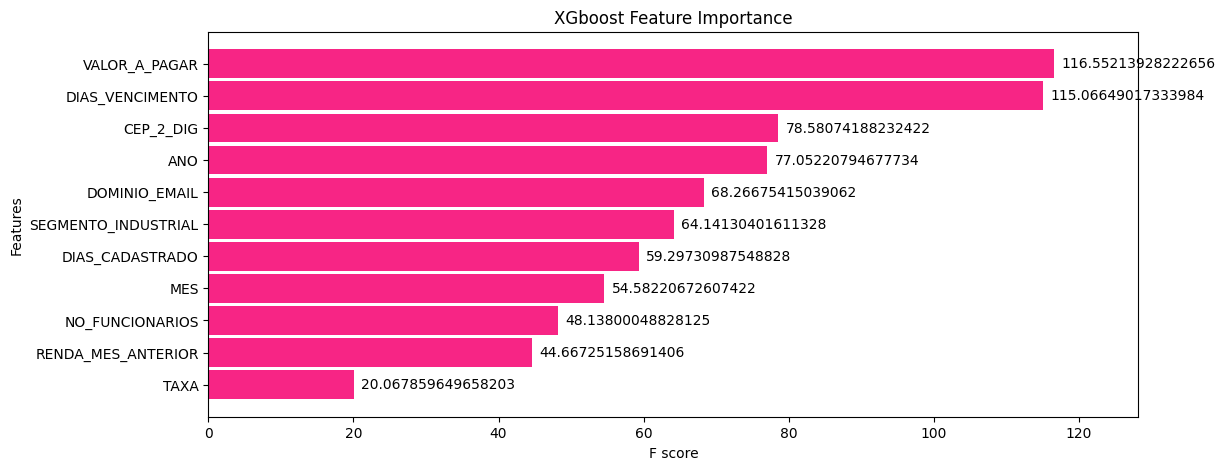

In [107]:
xgb_model_opt.fit(X,y)

xgboost.plot_importance(xgb_model_opt, 
                         importance_type='gain', 
                         title= 'XGboost Feature Importance', 
                         height=0.9, 
                         grid=False, 
                         color='#f72585'
                       );
# Obter a referência para a figura atual
fig = plt.gcf()  
fig.set_size_inches(12, 5);

In [108]:
%%time

lgbm_model_opt.fit(X, y)
explainer = shap.Explainer(lgbm_model_opt, X)
shap_values = explainer(X)

100%|===================| 77173/77414 [04:39<00:00]        

CPU times: user 4min 43s, sys: 149 ms, total: 4min 43s
Wall time: 4min 40s


In [109]:
shap.initjs()

In [110]:
df.loc[X.DIAS_VENCIMENTO>18].sort_values(by='DIAS_VENCIMENTO')

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_DEBITO,INADIMPLENTE,DIAS_CADASTRADO,DIAS_VENCIMENTO,ANO,SEMESTRE,MES,DIA
47235,8733525963966339207,2012-10-01,75.0,0,3,6,2,44.0,2020-05-01,137817.0,128.0,2020-05-21,2020-06-09,2020-06-09,55786.35,6.99,0,0,2789,19,2020,2,5,21
24944,8843432852270832388,2011-02-14,22.0,0,2,5,2,28.0,2019-08-01,592034.0,122.0,2019-08-02,2019-08-21,2019-08-21,43889.02,5.99,0,0,3091,19,2019,3,8,2
46564,4045739494965095560,2014-01-13,41.0,0,3,5,2,83.0,2020-06-01,73282.0,130.0,2020-06-11,2020-06-30,2020-06-30,26680.50,5.99,0,0,2341,19,2020,2,6,11
46554,4045739494965095560,2014-01-13,41.0,0,3,5,2,83.0,2020-05-01,156161.0,125.0,2020-05-24,2020-06-12,2020-06-12,23139.22,5.99,0,0,2323,19,2020,2,5,24
46553,4045739494965095560,2014-01-13,41.0,0,3,5,2,83.0,2020-05-01,156161.0,125.0,2020-05-24,2020-06-12,2020-06-12,16884.72,5.99,0,0,2323,19,2020,2,5,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70244,8535586342375301953,2017-11-07,32.0,0,2,5,2,36.0,2021-03-01,315577.0,130.0,2021-03-23,2021-04-13,2024-10-31,483816.00,11.99,-1297,0,1232,1318,2021,1,3,23
5167,8724731934863284019,2000-08-15,85.0,0,1,4,1,60.0,2018-11-01,178799.0,110.0,2018-11-04,2018-11-19,2024-01-28,40000.00,6.99,-1896,0,6655,1911,2018,4,11,4
5166,8724731934863284019,2000-08-15,85.0,0,1,4,1,60.0,2018-11-01,178799.0,110.0,2018-11-04,2018-11-19,2024-01-28,150000.00,6.99,-1896,0,6655,1911,2018,4,11,4
34543,1097345589386012260,2018-08-22,999.0,0,2,5,2,11.0,2019-11-01,134947.0,108.0,2019-11-20,2019-12-27,2025-08-27,659850.00,5.99,-2070,0,455,2107,2019,4,11,20


In [111]:
#idx 3     - Inadimplente --- SHAP = 2.218 --- +Valor Pagar = 1341, +CEP = 65, +Renda Ant = 113366, +Cadastro = 1834
#idx 64690 - Inadimplente --- SHAP = 2.071 --- +Valor Pagar = 1360, +CEP = 28, -Vencimento = 15, -Ano = 2021
#idx 49360 - Inadimplente --- SHAP = 0.809 --- +Vencimento = 21, +CEP = 68, +Cadastro = 2315, +Email = GMAIL
#idx 14947 - Inadimplente --- SHAP = 0.916 --- +CEP = 26, Vencimento = 30, +Cadastro = 2523, -Valor Pagar = 79218
#idx 16 - Regular
#idx 72364 - Regular --- Dias Vencimento = 16, Valor Pagar = 29886, CEP = 76, Cadasrto = 3075
idx = 46564
df.iloc[idx,:]

ID_CLIENTE                4045739494965095560
DATA_CADASTRO             2014-01-13 00:00:00
DDD                                      41.0
FLAG_PF                                     0
SEGMENTO_INDUSTRIAL                         3
DOMINIO_EMAIL                               5
PORTE                                       2
CEP_2_DIG                                83.0
SAFRA_REF                 2020-06-01 00:00:00
RENDA_MES_ANTERIOR                    73282.0
NO_FUNCIONARIOS                         130.0
DATA_EMISSAO_DOCUMENTO    2020-06-11 00:00:00
DATA_PAGAMENTO            2020-06-30 00:00:00
DATA_VENCIMENTO           2020-06-30 00:00:00
VALOR_A_PAGAR                         26680.5
TAXA                                     5.99
DIAS_DEBITO                                 0
INADIMPLENTE                                0
DIAS_CADASTRADO                          2341
DIAS_VENCIMENTO                            19
ANO                                      2020
SEMESTRE                          

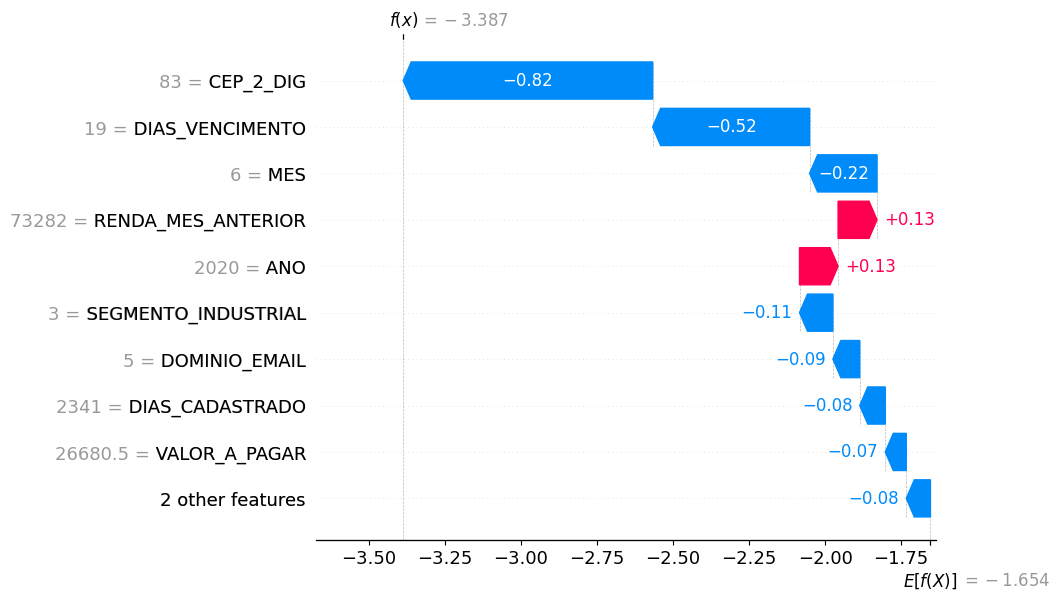

In [112]:
shap.plots.waterfall(shap_values[idx,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


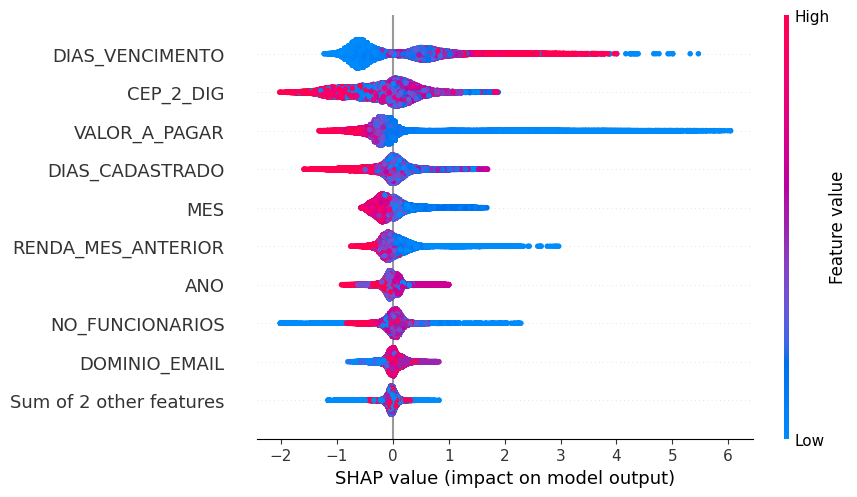

In [113]:
shap.plots.beeswarm(shap_values)

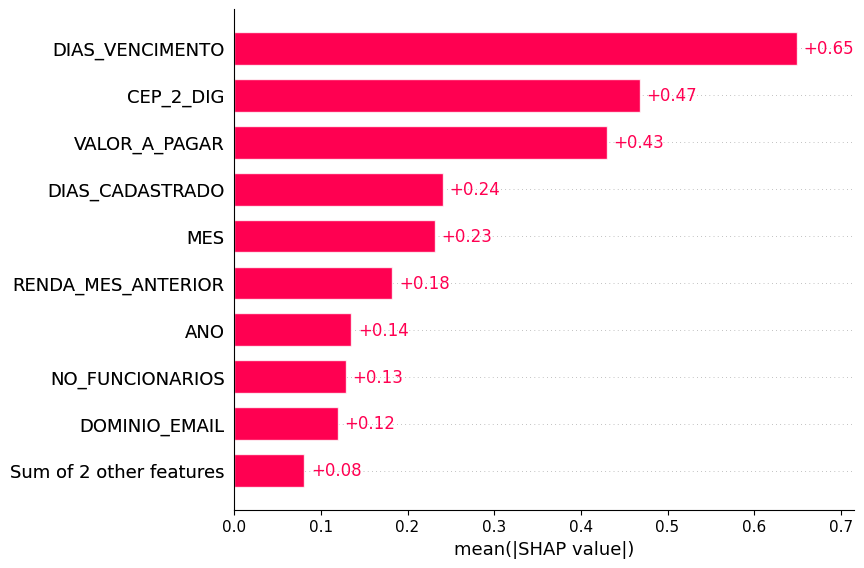

In [114]:
shap.plots.bar(shap_values)

Apartir do conhecimento de negócio, da analise exploratória dos dados e das analises de importancia das features anteriormente obtivemos alguns insights.

- Na perspectiva do modelo clientes que possuem DIAS_VENCIMENTO mais longo, acima de 20 dias, são mais propensos a serem inadimplentes.

- Os meses de fevereiro e março são os que possuem mais inadimplentes e os meses agosto e setembro são os que possuem menos inadimplentes de acordo com o mes em que a documentação foi emitida.

- Na perspectiva do modelo quanto mais baixo o valor requisitado de crédito pelo cliente, valores abixo de 15000, maiores as chances dele ser inadimplente.

- Na perspectiva do modelo, cliente mais antigos, por volta dos 18 anos possuem menos tendencia a serem inadimplentes.

Os valores sugeridos são genéricos a decisão do modelo levam todos os fatores em conjunto não apenas valores isolados.

**Observações:**

Importante resaltar que as features importance dizem respesteito do que o modelo considera importante para determinar a predição, não significa que necessariamente essas são as caracteristicas mais importantes no mundo real

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Submission</p></div> 

In [115]:
X_test = test_raw.copy()

In [116]:
X_test = Preprocessing(X_test)

In [117]:
X_test.isna().sum().sum()

0

In [118]:
X_test, FEATURES,_ = Preparation(X_test)

In [119]:
X_test = X_test[FEATURES]

In [120]:
X_test.isna().sum()

VALOR_A_PAGAR          0
TAXA                   0
RENDA_MES_ANTERIOR     0
NO_FUNCIONARIOS        0
SEGMENTO_INDUSTRIAL    0
DOMINIO_EMAIL          0
CEP_2_DIG              0
DIAS_CADASTRADO        0
DIAS_VENCIMENTO        0
ANO                    0
MES                    0
dtype: int64

In [121]:
lgbm_model.fit(X, y)
y_test = lgbm_model.predict_proba(X_test)
y_test = y_test[:,1]

In [122]:
y_test

array([0.01200694, 0.03016543, 0.03259248, ..., 0.02889494, 0.00610263,
       0.01083187])

In [123]:
test = test_raw.copy()
test['INADINPLENTE_PROBA'] = y_test

In [124]:
test

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,INADINPLENTE_PROBA
0,5058298901476893676,2014-03-30,54,NaN,Serviços,GMAIL,MEDIO,99,2021-07,467430.0,154.0,2021-07-14,2021-08-04,11204.75,4.99,0.012007
1,274692171162531764,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,2021-07,417192.0,104.0,2021-07-08,2021-08-23,60718.50,5.99,0.030165
2,274692171162531764,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,2021-07,417192.0,104.0,2021-07-11,2021-08-25,60718.50,5.99,0.032592
3,274692171162531764,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,2021-07,417192.0,104.0,2021-07-16,2021-08-30,62250.00,5.99,0.032592
4,465309249432033993,2014-07-23,69,NaN,Comércio,GMAIL,GRANDE,76,2021-07,873938.0,119.0,2021-07-05,2021-07-30,26593.95,6.99,0.037538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12270,705648002974742140,2020-01-26,67,NaN,Indústria,YAHOO,MEDIO,79,2021-11,NaN,NaN,2021-11-25,2021-12-13,47010.00,6.99,0.141288
12271,4993499380140734678,2015-11-24,31,NaN,Serviços,GMAIL,PEQUENO,37,2021-11,311422.0,150.0,2021-11-25,2021-12-13,122875.35,8.99,0.005148
12272,4614484019183480654,2011-02-14,51,NaN,Indústria,YAHOO,MEDIO,93,2021-11,NaN,NaN,2021-11-26,2028-09-30,302200.00,5.99,0.028895
12273,1299146298565441811,2000-08-15,21,NaN,Serviços,HOTMAIL,MEDIO,21,2021-11,220341.0,122.0,2021-11-26,2021-12-13,143791.85,5.99,0.006103


In [125]:
test[['ID_CLIENTE','SAFRA_REF','INADINPLENTE_PROBA']].to_csv("submission.csv")

# <div style="color:white;display:fill;border-radius:5px;background-color:#560BAD;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%">Next Step</p></div> 

- Melhores estratégias para imputação de dados, quando não encontrado por exemplo o SAFRA_REF da RENDA_MES_ANTERIOR e NO_FUNCIONARIOS um codigo mais aprimorado seria procurar por o mês anterior mais atual caso exista esse registro.

- Testar mais hiperparametros e usar mais trials no Optuna, principalmente na questão de regularização os valores de L1 e L2 variaram bastante.